# Analytics

#### Date: 2021/01

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM: SysArq

##### Semester: 2021/01
##### Professor: Hilmer Neri

##### Members:

- Joao Gabriel Rossi
- Paulo Vitor Coelho
- Joao Matheus
- Ivan Diniz Dobbin
- Gabriel Marcolino
- Carlos Eduardo Roriz
- Lorenzo Santos

### LIBRARIES

In [2]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Datetime
from datetime import datetime

### GRAPH SETTINGS

In [3]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [5]:
jsons = glob('../analytics-raw-data/*.json') # add the path here

In [6]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"PC-GO1-(.*?)-*-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [7]:
base_component_df = create_base_component_df(jsons)

In [8]:
base_component_df.head(10)

,bestValue,metric,value,filename,repository,version
18,True,duplicated_lines_density,0.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
19,NaN,functions,41,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
20,True,security_rating,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
21,NaN,files,16,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
22,NaN,complexity,42,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
23,NaN,ncloc,878,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
24,False,coverage,97.3,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
25,True,reliability_rating,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
26,False,comment_lines_density,7.7,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
54,True,duplicated_lines_density,0.0,fga-eps-mds-2021_1-PC-GO1-Archives-13-09-2021-...,Archives,13-09-2021-15-00


#### Create dataframe per file

In [9]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [10]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns, dtype=object)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)
        
        file_component_df_py = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'py')
        file_component_df_js = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')

        file_component_df_py['filename'] = os.path.basename(i)
        file_component_df_js['filename'] = os.path.basename(i)

        df = df.append(file_component_df_js, ignore_index=True)
        df = df.append(file_component_df_py, ignore_index=True)
          
    aux_df = df['filename'].str.split(r"PC-GO1-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [11]:
file_component_df = create_file_df(jsons)

In [12]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
131,archives_app/migrations/0001_initial.py,0,0,1.2,0.0,0.0,85,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
132,archives_app/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
133,archives_app/migrations/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
134,project/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
135,archives_app/admin.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
136,archives_app/apps.py,0,0,0.0,0.0,100.0,3,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
137,project/asgi.py,0,0,66.7,0.0,NaN,4,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
138,manage.py,1,2,16.7,0.0,NaN,15,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
139,archives_app/models.py,0,0,0.0,0.0,100.0,39,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
140,archives_app/serializers.py,0,0,0.0,0.0,100.0,65,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47


#### Create dataframe per repository

In [13]:
archives_df = file_component_df[file_component_df['repository'] == 'Archives']
profile_df = file_component_df[file_component_df['repository'] == 'Profile']
frontend_df = file_component_df[file_component_df['repository'] == 'Frontend']

In [14]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        ncloc += int(each)
    
    return ncloc

### Measure calculations accordng to Q-Rapids quality model

# Quality Aspect - Maintainability

## Factor - Code Quality 

### Metric calculations

##### COMPLEXITY

In [15]:
def m1(df):
    """
    Is better to have more functions than less functions but more complex ones with greater number of paths
    m1 = 1 is the best possible result
    """
    density_non_complex_files = len(df[((df['complexity'].astype(float)/df['functions'].astype(float)) < 10) | (df['functions'].astype(int) == 0).all()])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [16]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [17]:
def m3(df):
    """
    Is better to have less duplicated lines
    m3 = 1 is the best possible result
    """
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability

## Factor - Testing Status

##### Passed tests

In [18]:
def m4(df):
    """
    m4 = 1 is the optimal result
    """
    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

#### Fast test builds

In [19]:
def m5(df):
    """
    m5 = 1 is the optimal result
    """
    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

#### Test coverage

In [20]:
def m6(df):
    """
    m6 = 1 is the optimal result
    """
    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage


### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [21]:
def drop_unnecessary_files(df):
    new_df = df[~df['path'].str.contains('test')]
    new_df = new_df[~new_df['path'].str.contains('init')]
    new_df = new_df[~new_df['path'].str.contains('manage')]
    new_df = new_df[~new_df['path'].str.contains('asgi')]
    new_df = new_df[~new_df['path'].str.contains('wsgi')]
    new_df = new_df[~new_df['path'].str.contains('admin')]
    return new_df

In [22]:
new_archives_df = drop_unnecessary_files(archives_df)
new_frontend_df = drop_unnecessary_files(frontend_df)
new_profile_df = drop_unnecessary_files(profile_df)

In [23]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m4(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm6': m6_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [24]:
archives_metrics = create_metrics_df(new_archives_df)
profile_metrics = create_metrics_df(new_profile_df)
frontend_metrics = create_metrics_df(new_frontend_df)

### Data visualization

- You must do this for each of your repositories

# ARCHIVES

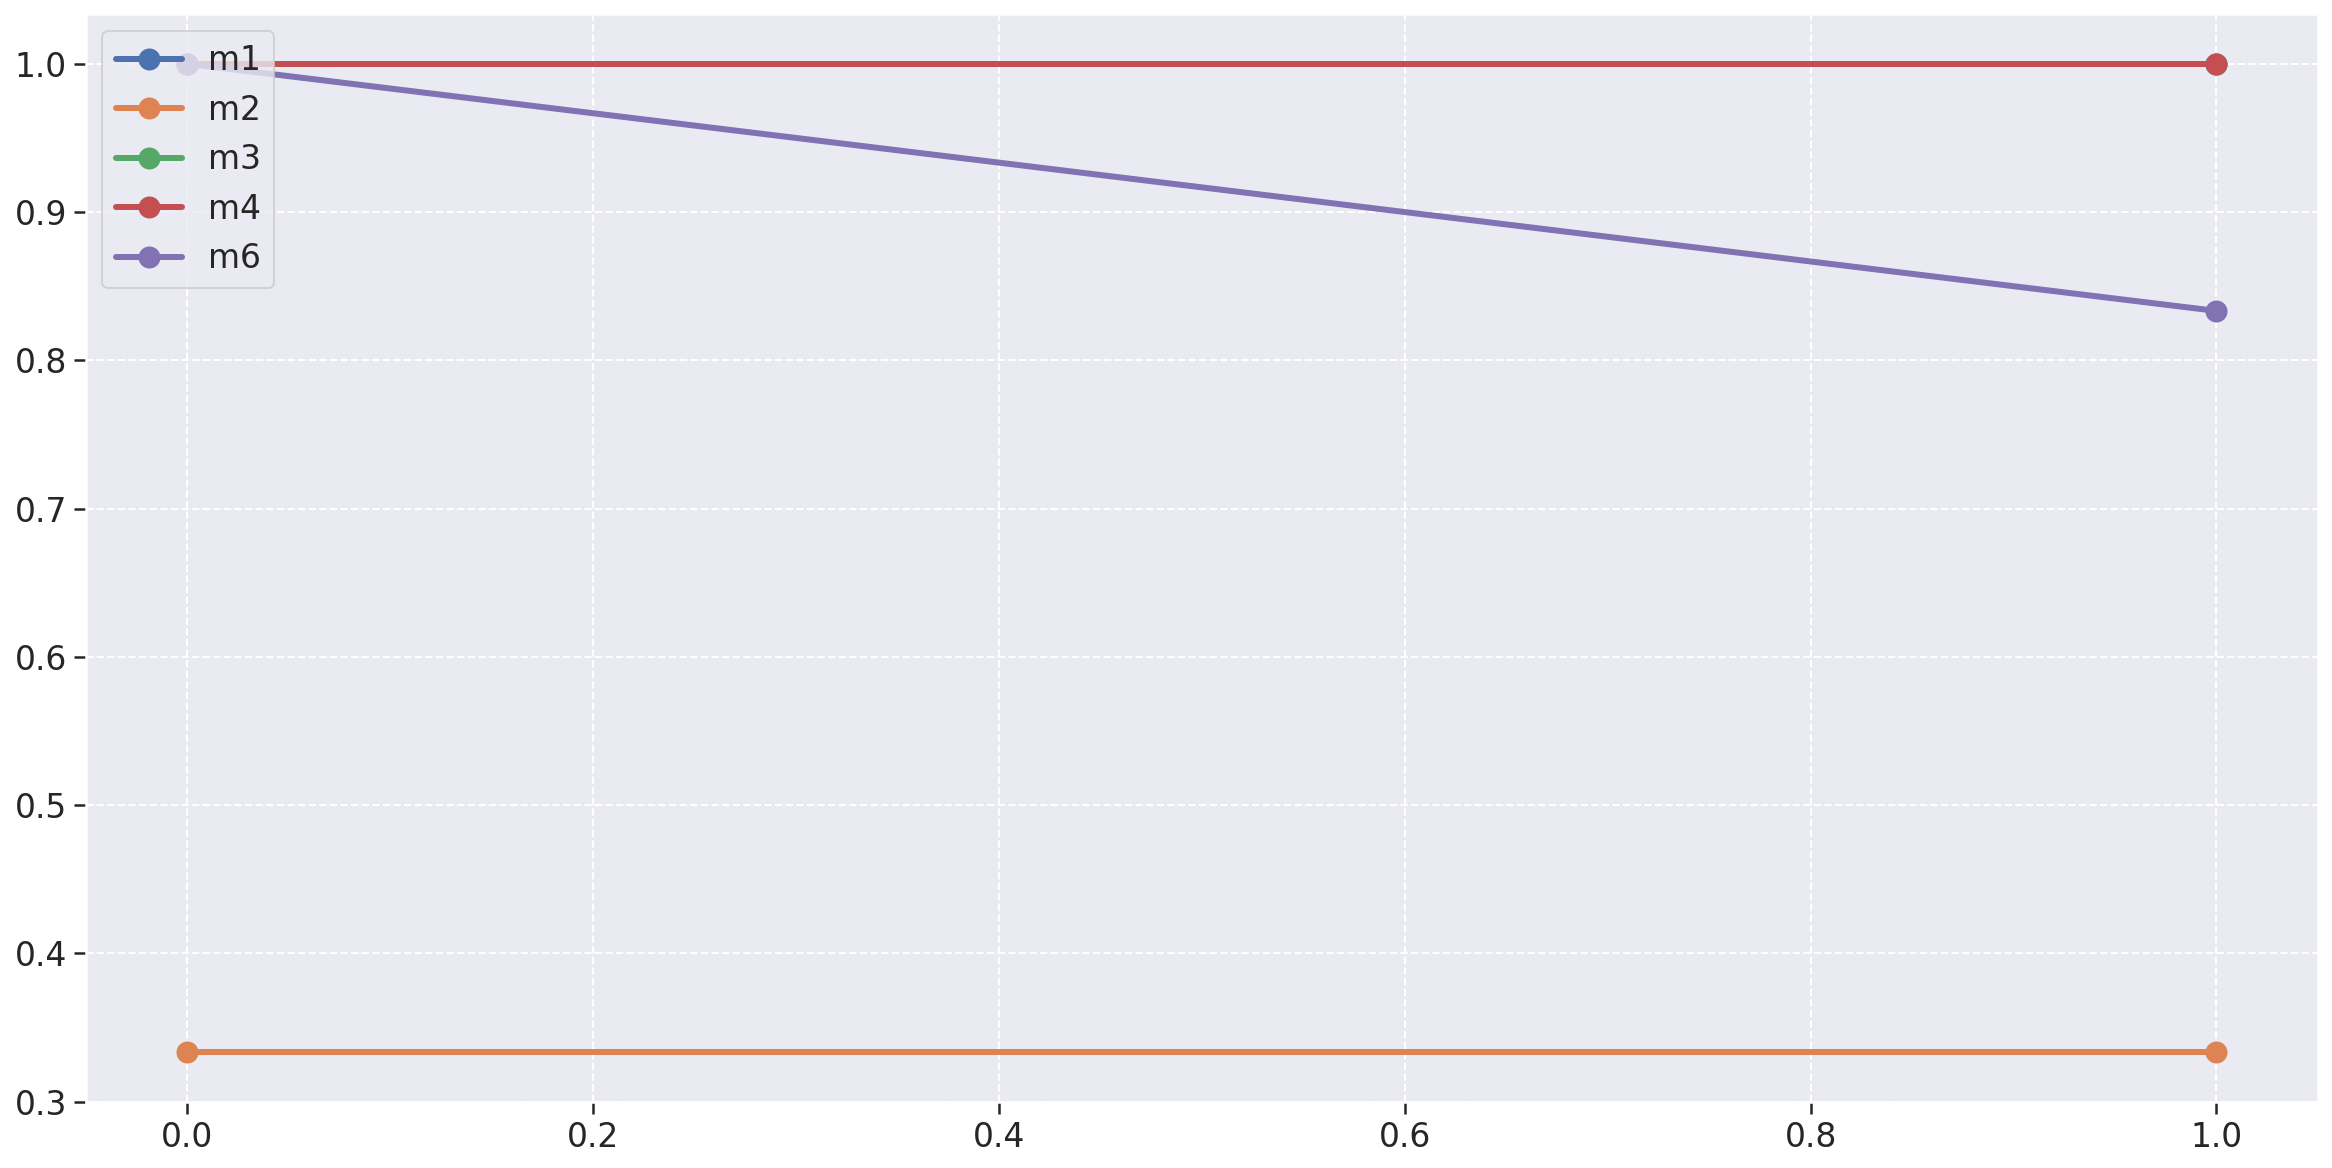

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.plot(archives_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(archives_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(archives_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(archives_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(archives_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')

plt.legend(loc='upper left')

# Profile

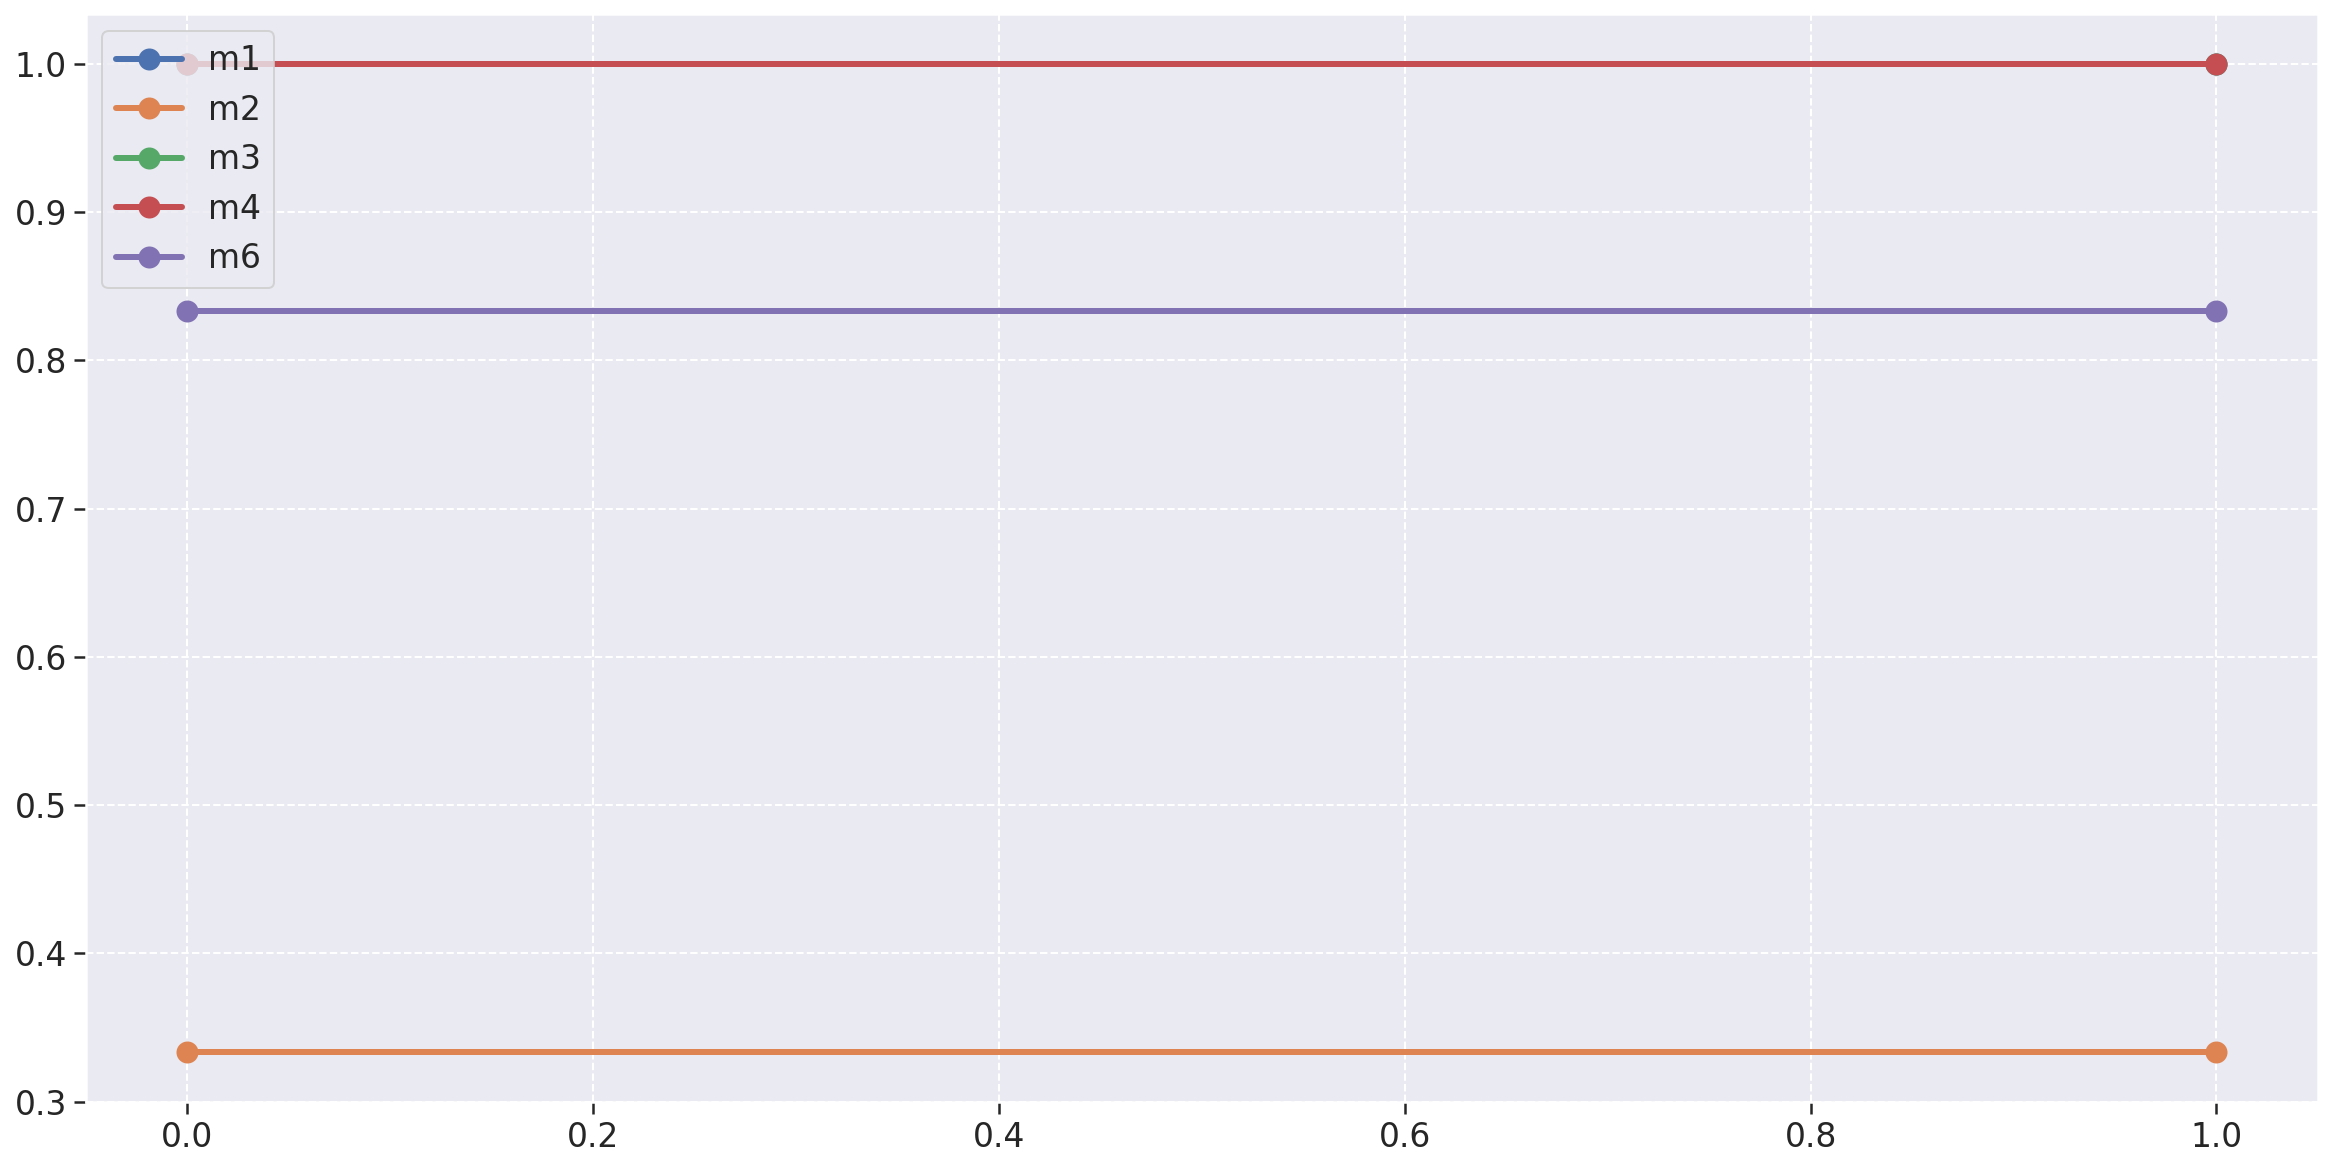

In [26]:
fig = plt.figure(figsize=(20, 10))

plt.plot(profile_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(profile_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(profile_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(profile_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(profile_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')

plt.legend(loc='upper left')

# Frontend

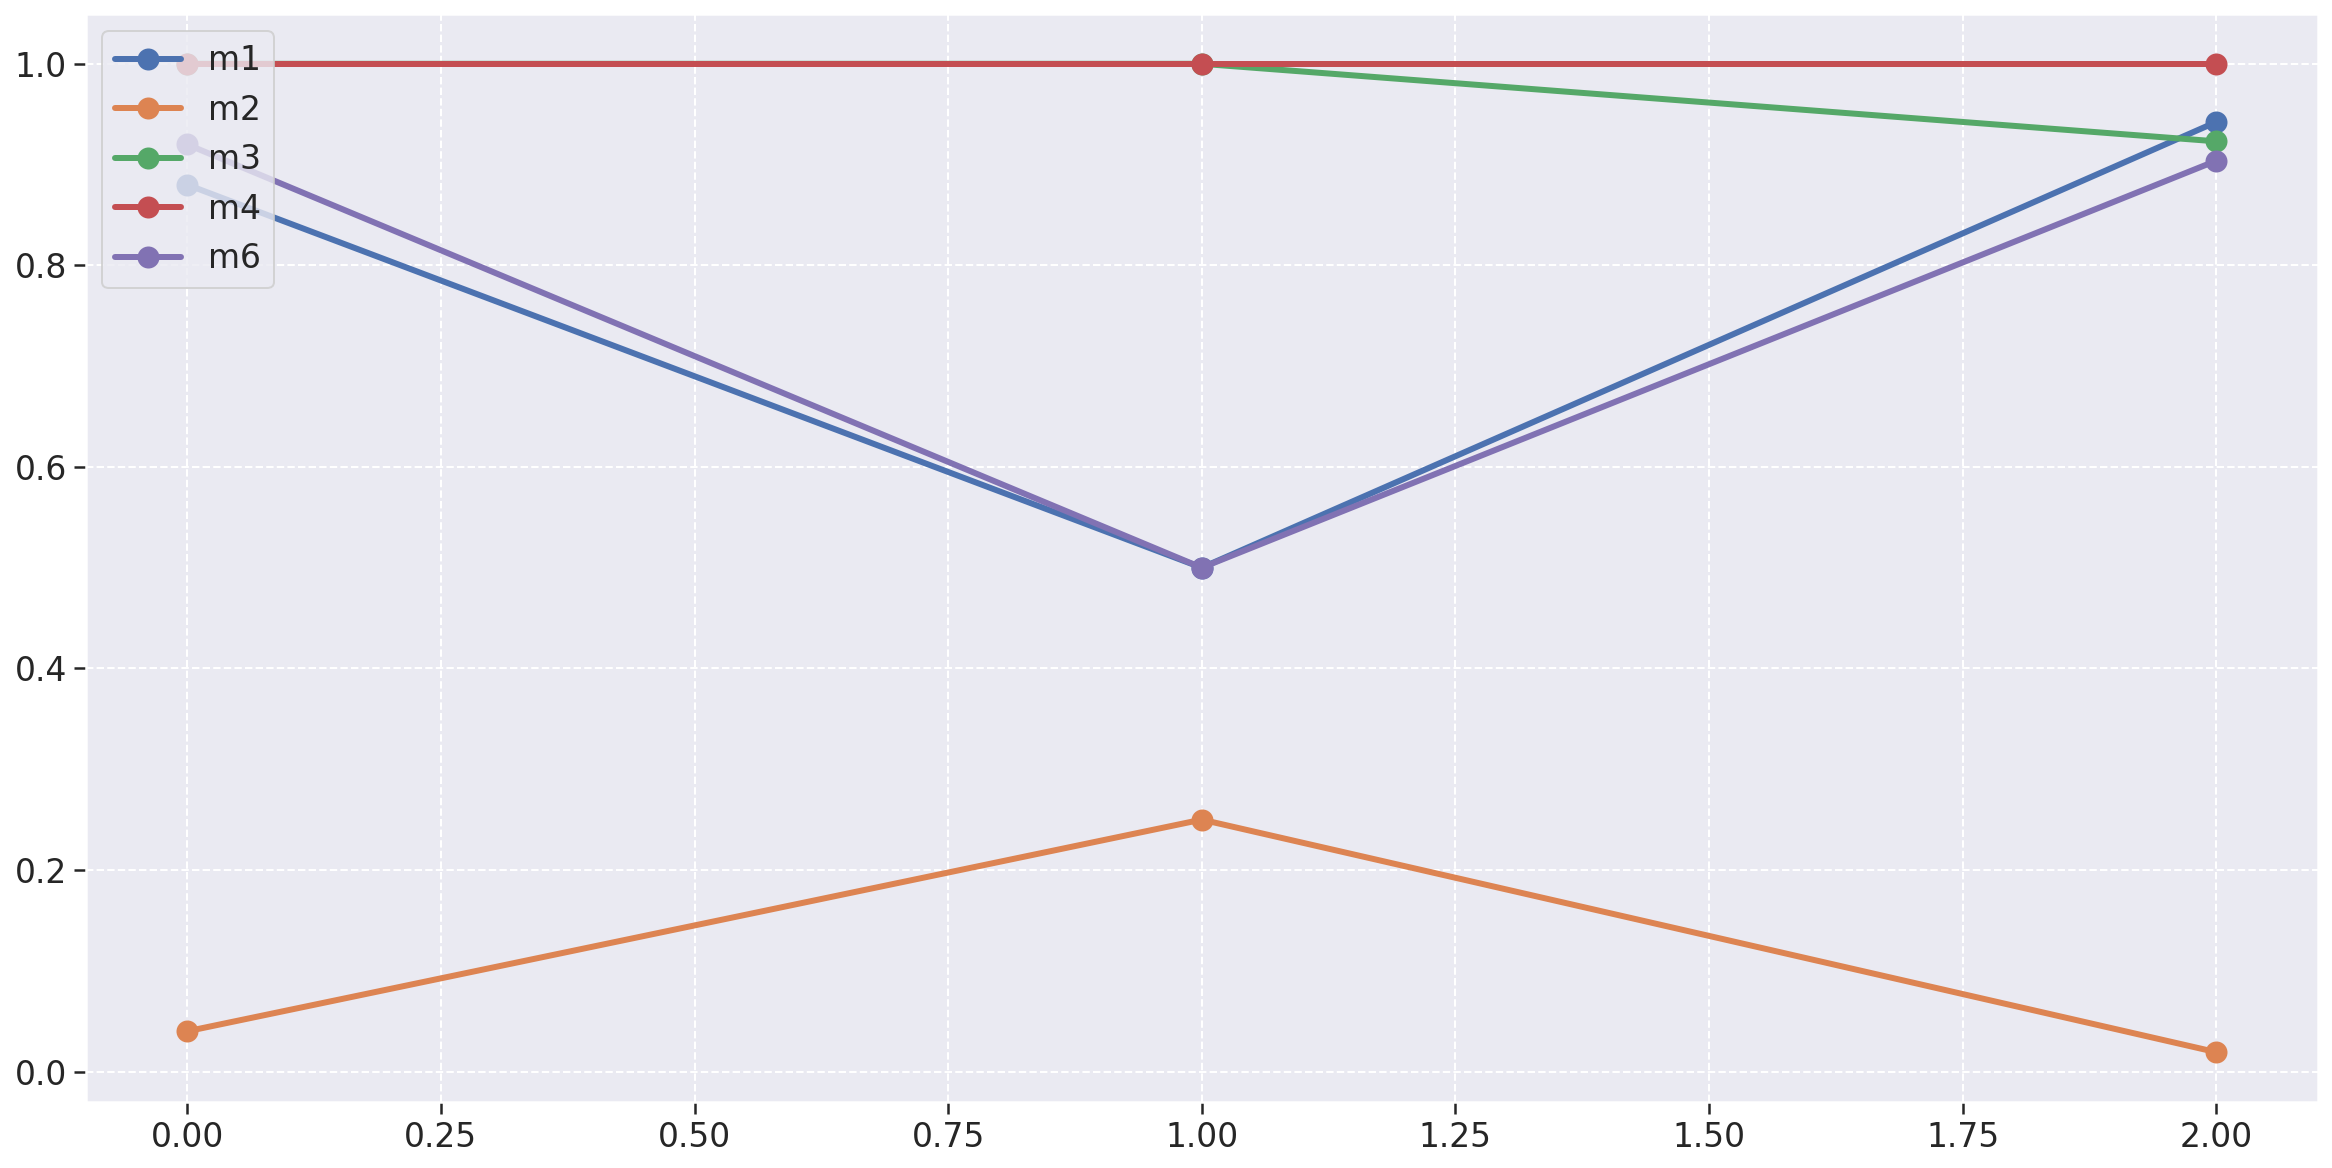

In [27]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(frontend_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(frontend_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(frontend_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(frontend_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')

plt.legend(loc='upper left')

### Sub characteristic aggregation

- You must do this for each of your repositories

In [28]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33

pm4 = 0.3
pm6 = 0.7

archives_metrics['code_quality'] = ((archives_metrics['m1']*pm1)+(archives_metrics['m2']*pm2)+(archives_metrics['m3']*pm3))*psc1
profile_metrics['code_quality'] = ((profile_metrics['m1']*pm1)+(profile_metrics['m2']*pm2)+(profile_metrics['m3']*pm3))*psc1
frontend_metrics['code_quality'] = ((frontend_metrics['m1']*pm1)+(frontend_metrics['m2']*pm2)+(frontend_metrics['m3']*pm3))*psc1

archives_metrics['testing_status'] = ((archives_metrics['m4']*pm4)+(archives_metrics['m6']*pm6))*psc2
profile_metrics['testing_status'] = ((profile_metrics['m4']*pm4)+(profile_metrics['m6']*pm6))*psc2
frontend_metrics['testing_status'] = ((frontend_metrics['m4']*pm4)+(frontend_metrics['m6']*pm6))*psc2

## Code Quality 

No handles with labels found to put in legend.


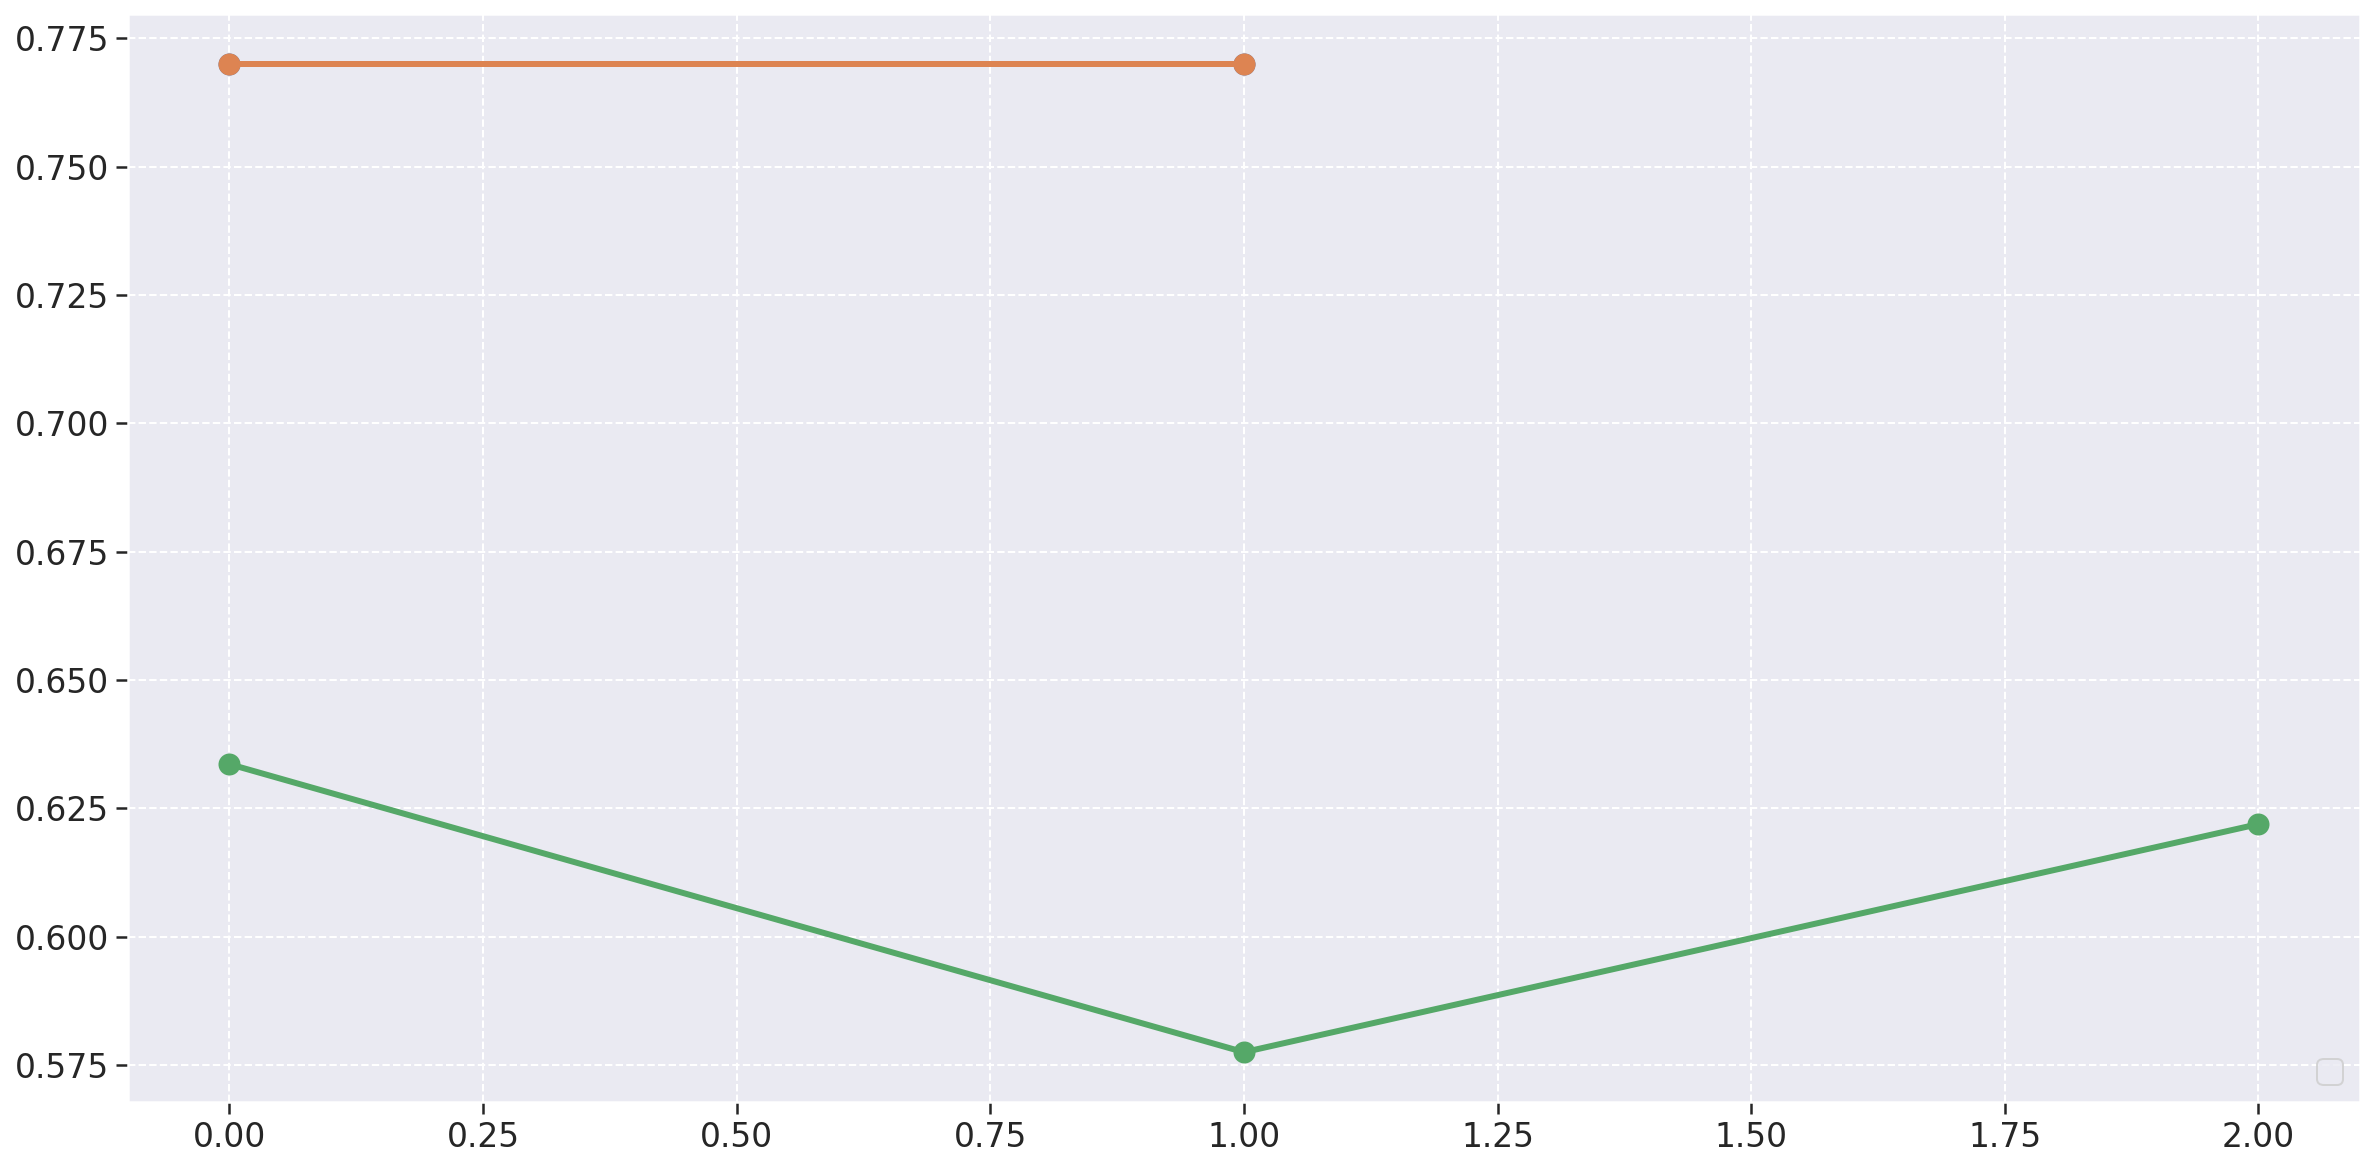

In [29]:
fig = plt.figure(figsize=(20, 10))

plt.plot(archives_metrics['code_quality'], linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['code_quality'], linewidth=3, marker='o', markersize=10)
plt.plot(frontend_metrics['code_quality'], linewidth=3, marker='o', markersize=10)

plt.legend(loc='lower right')

## Testing Status

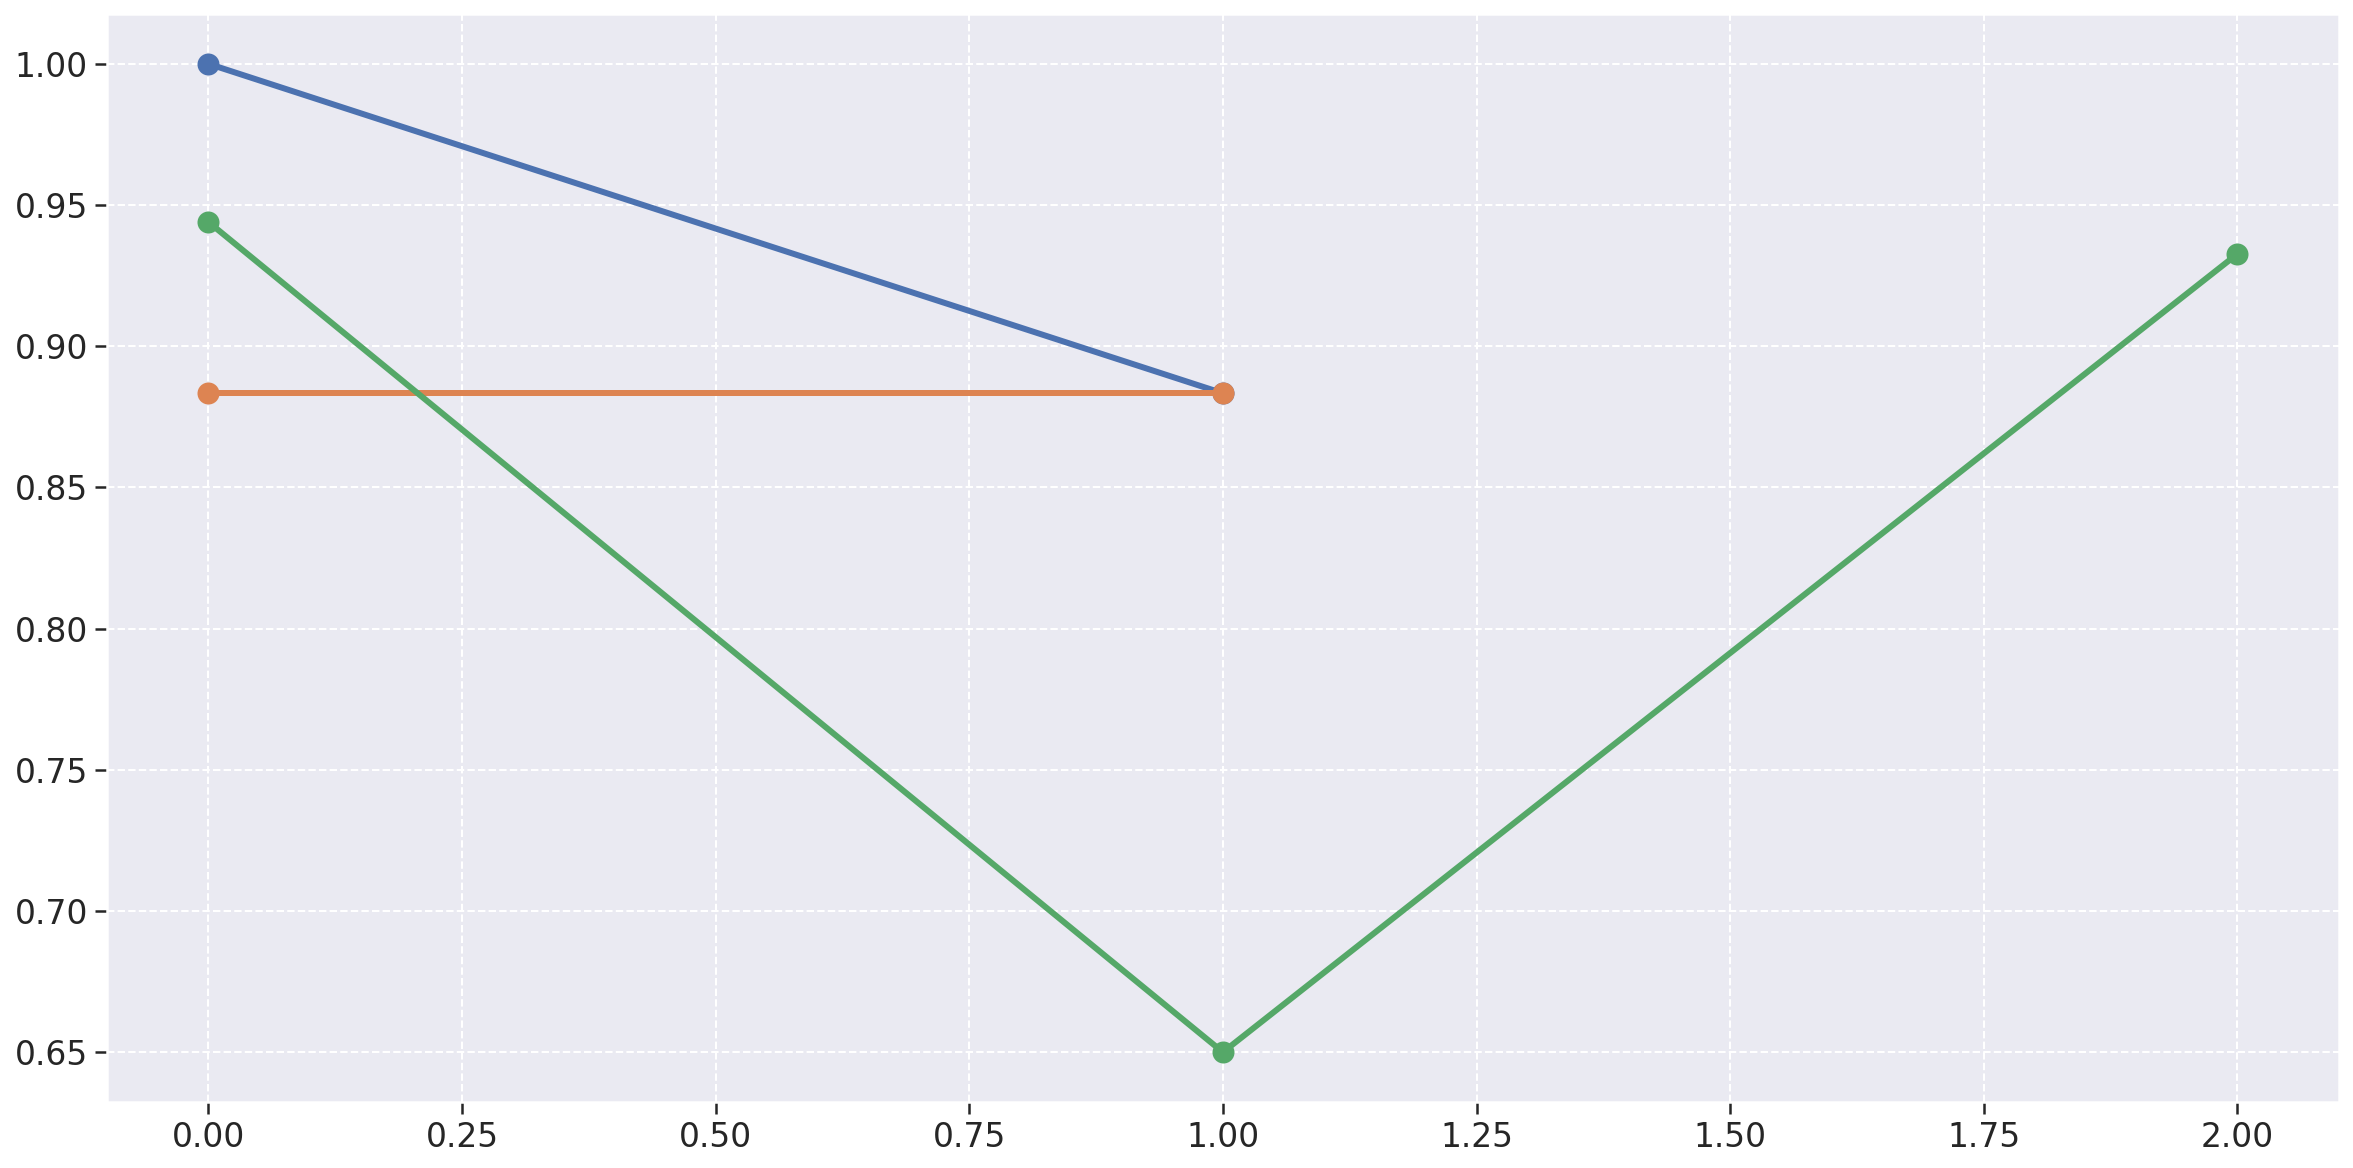

In [30]:
fig = plt.figure(figsize=(20, 10))

plt.plot(archives_metrics['testing_status'], linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['testing_status'], linewidth=3, marker='o', markersize=10)
plt.plot(frontend_metrics['testing_status'], linewidth=3, marker='o', markersize=10)

## All Metrics

In [31]:
metrics_df = pd.concat([archives_metrics, profile_metrics, frontend_metrics], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

In [32]:
metrics_df

,m1,m2,m3,m4,m6,repository,version,ncloc,code_quality,testing_status,maintainability,Reliability,total
0,1.000000,0.333333,1.000000,1.0,1.000000,Archives,03-10-2021-15-47,239,0.770000,1.000000,0.385000,0.500000,0.885000
1,1.000000,0.333333,1.000000,1.0,0.833333,Archives,13-09-2021-15-00,109,0.770000,0.883333,0.385000,0.441667,0.826667
2,1.000000,0.333333,1.000000,1.0,0.833333,Profile,03-10-2021-15-48,112,0.770000,0.883333,0.385000,0.441667,0.826667
3,1.000000,0.333333,1.000000,1.0,0.833333,Profile,13-09-2021-14-00,112,0.770000,0.883333,0.385000,0.441667,0.826667
4,0.880000,0.040000,1.000000,1.0,0.920000,Frontend,03-10-2021-15-49,1417,0.633600,0.944000,0.316800,0.472000,0.788800
5,0.500000,0.250000,1.000000,1.0,0.500000,Frontend,13-09-2021-20-00,48,0.577500,0.650000,0.288750,0.325000,0.613750
6,0.942308,0.019231,0.923077,1.0,0.903846,Frontend,17-10-2021-15-30,4874,0.621923,0.932692,0.310962,0.466346,0.777308


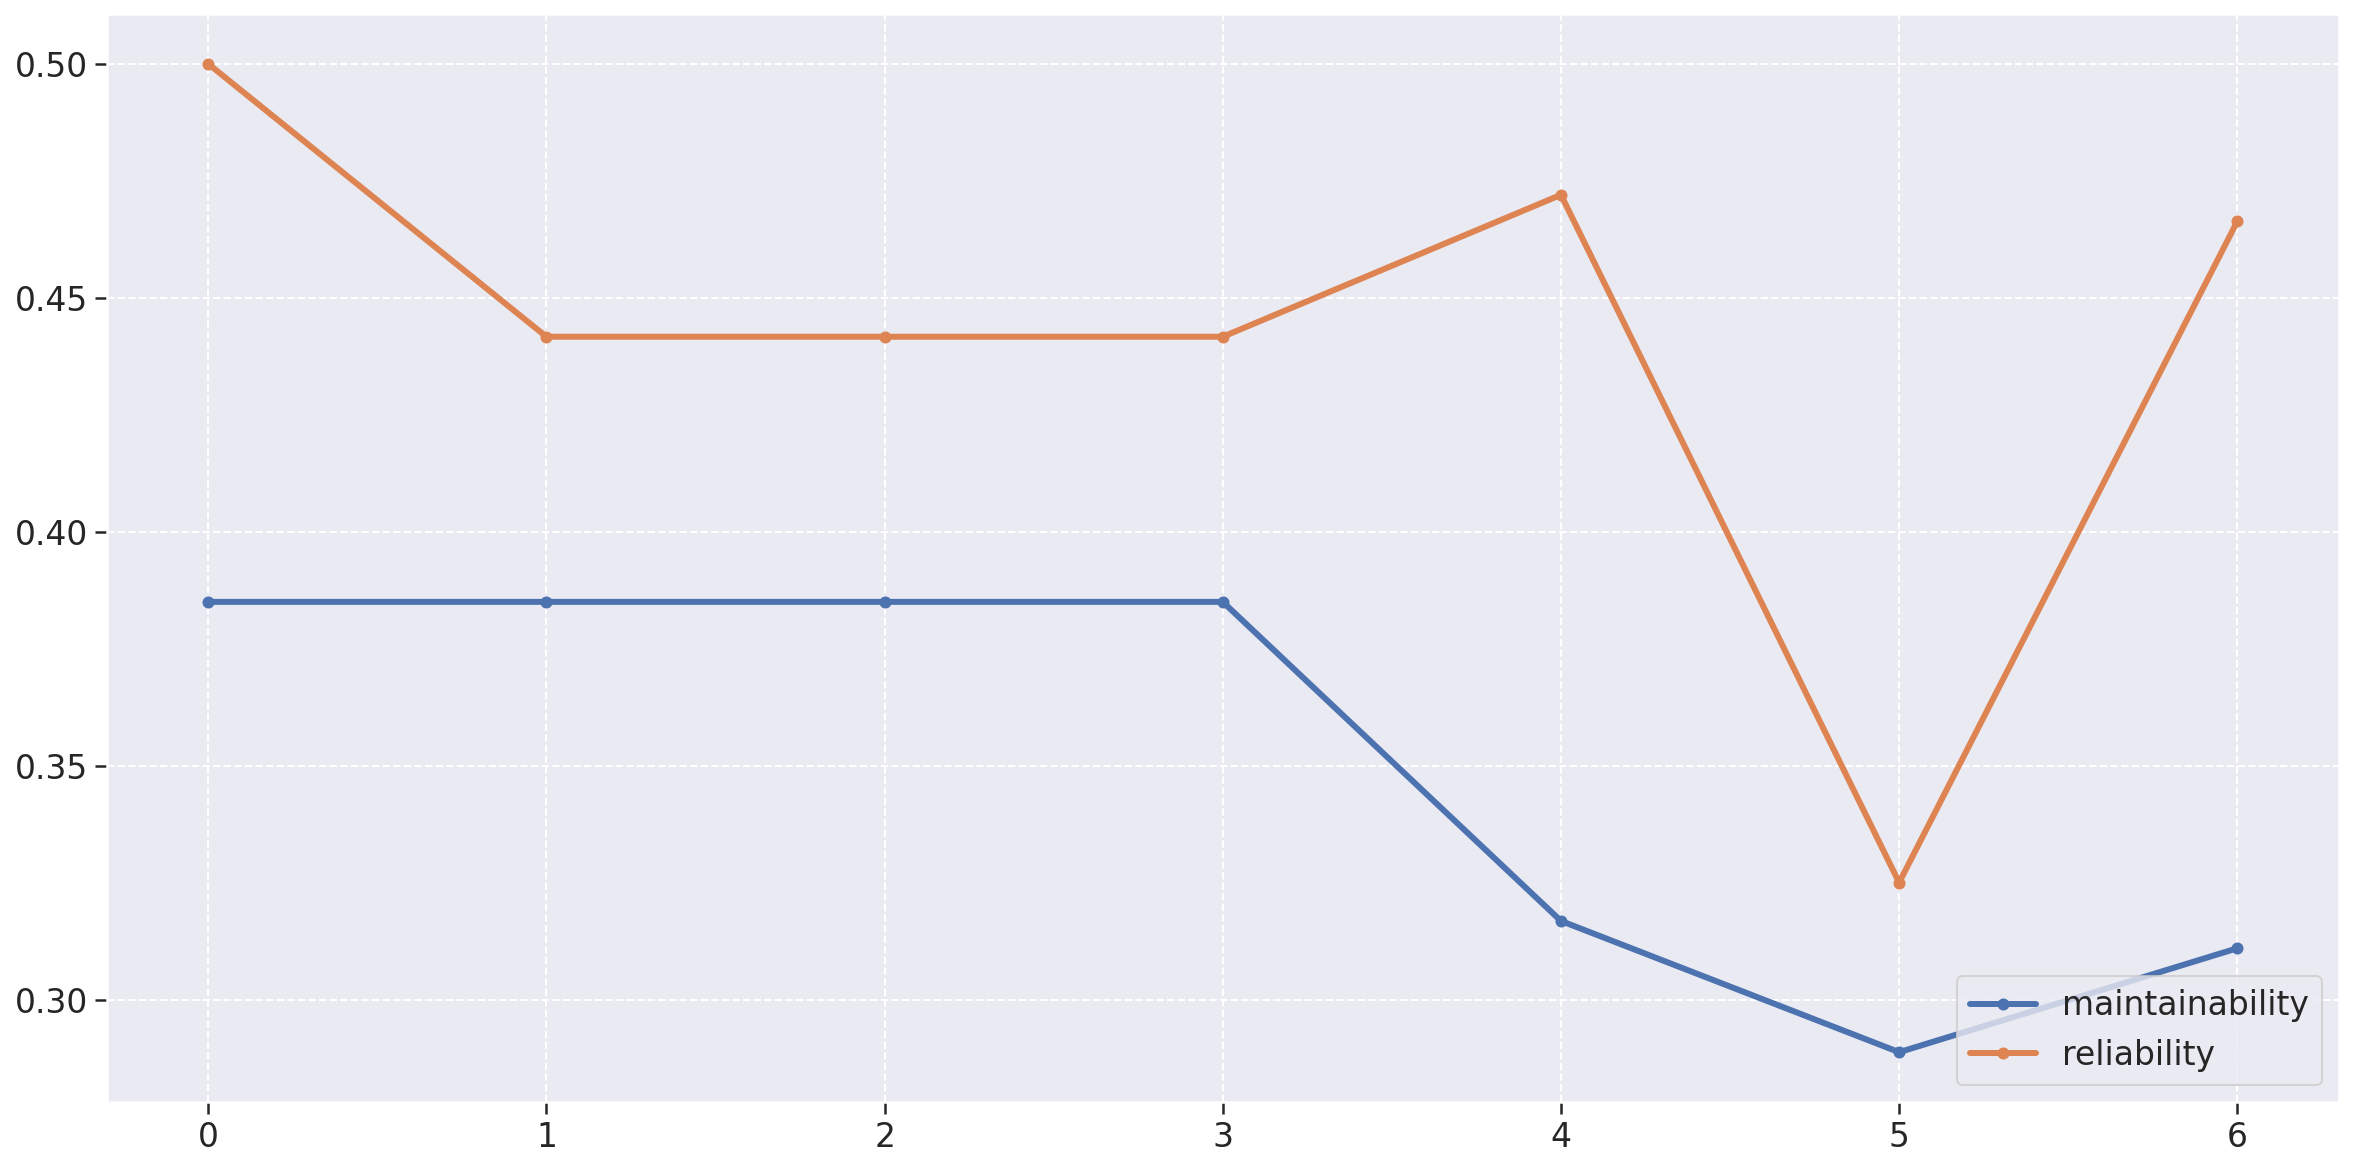

In [33]:
fig = plt.figure(figsize=(20, 10))

plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', markersize=5, label='maintainability')
plt.plot(metrics_df['Reliability'], linewidth=3, marker='o', markersize=5, label='reliability')

plt.legend(loc='lower right')

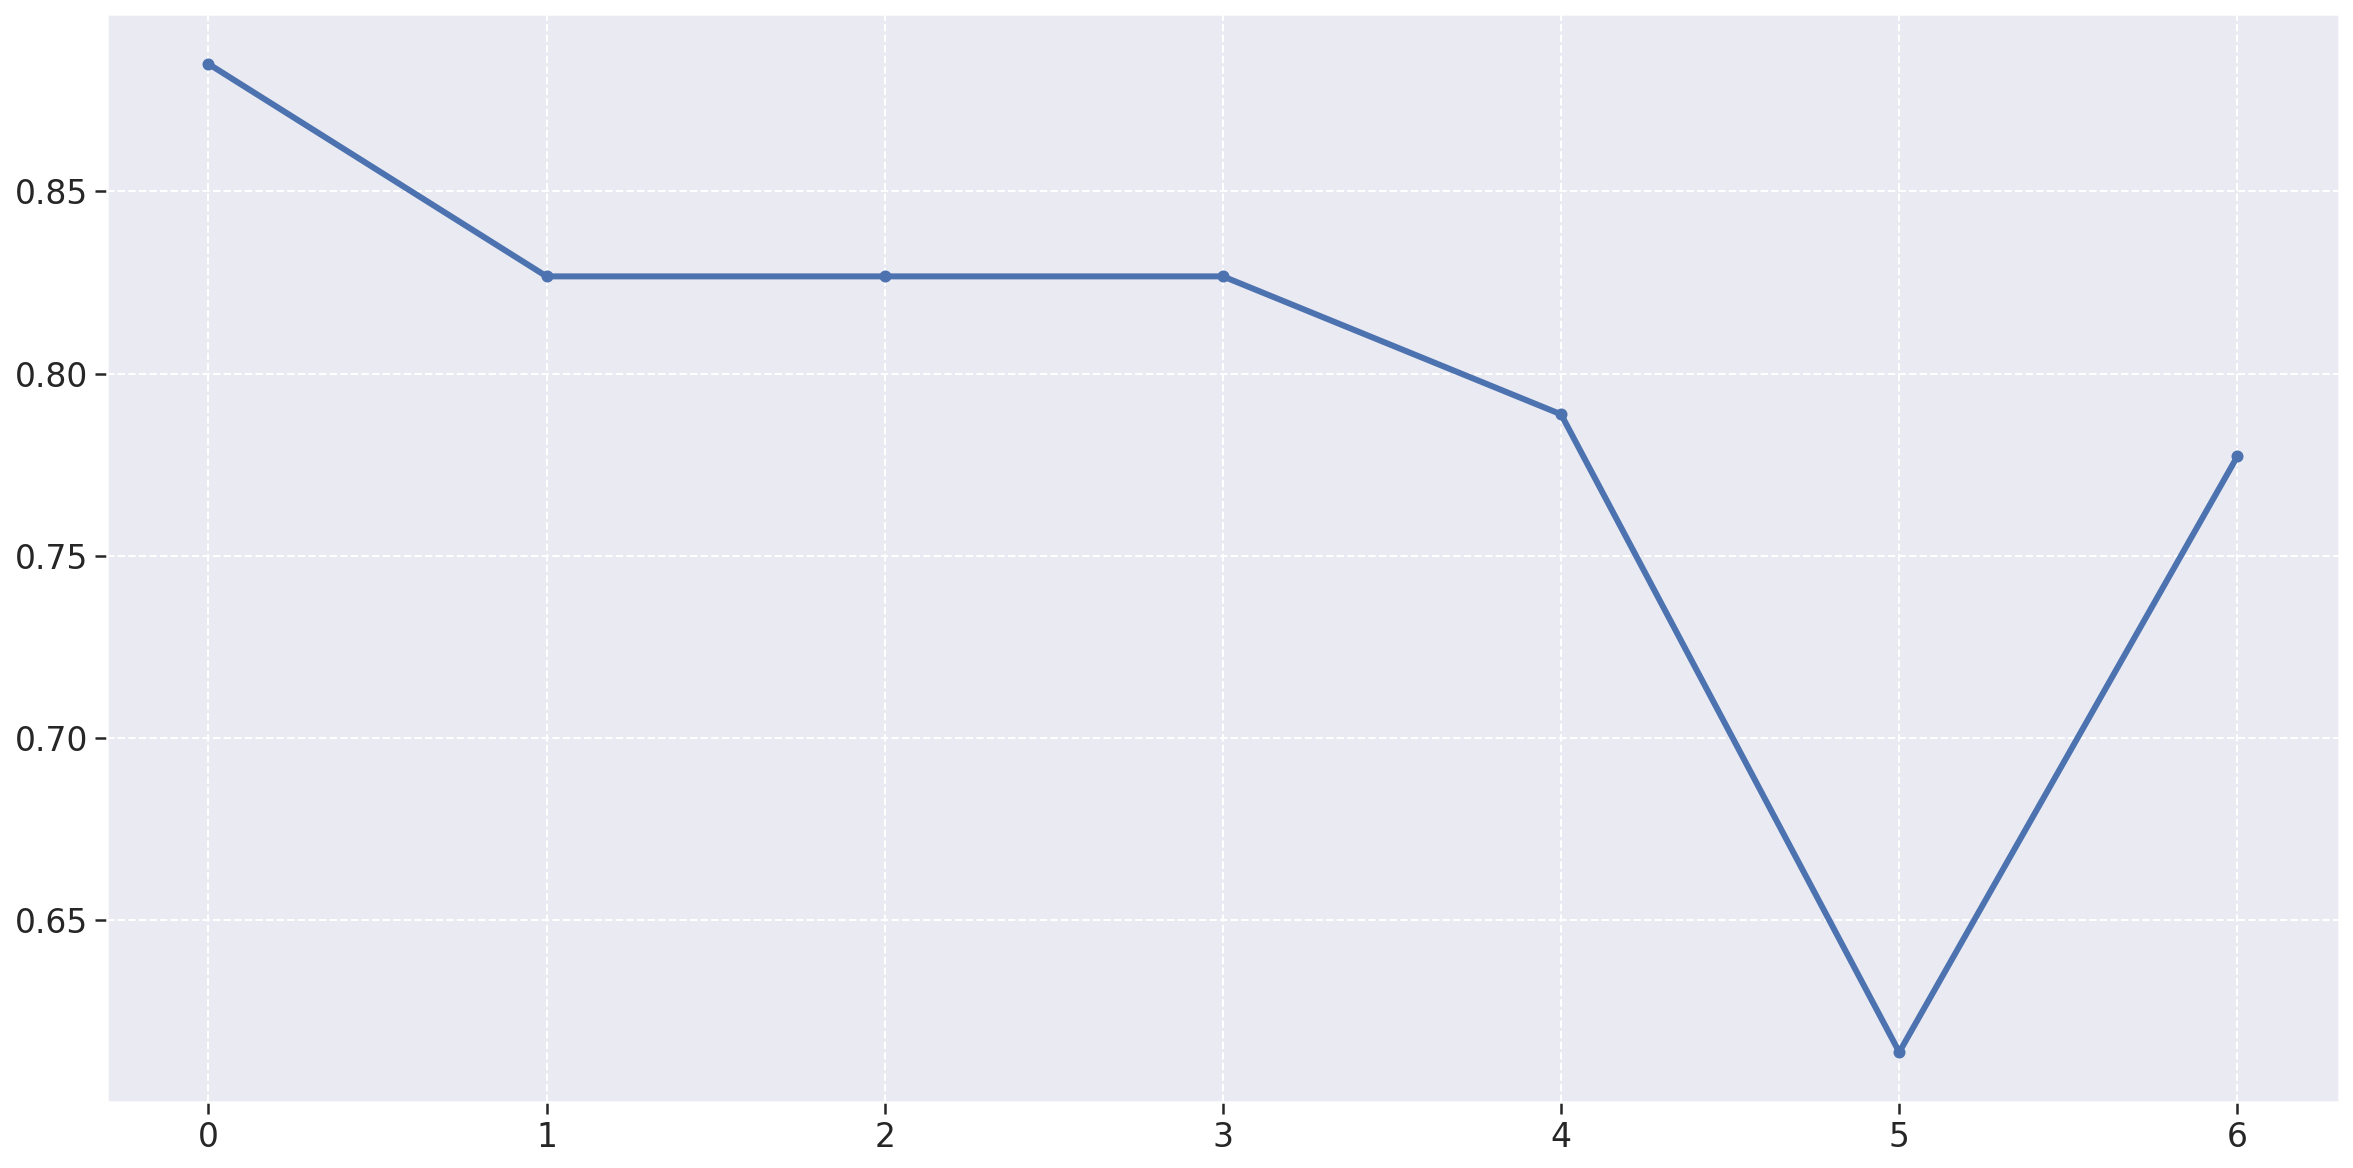

In [34]:
fig = plt.figure(figsize=(20, 10))

plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5)

# Descriptive Statistics

# Archives

## Histograms

### Code Quality

In [42]:
archives_metrics

,m1,m2,m3,m4,m6,repository,version,ncloc,code_quality,testing_status
0,1.0,0.333333,1.0,1.0,1.000000,Archives,03-10-2021-15-47,239,0.77,1.000000
1,1.0,0.333333,1.0,1.0,0.833333,Archives,13-09-2021-15-00,109,0.77,0.883333


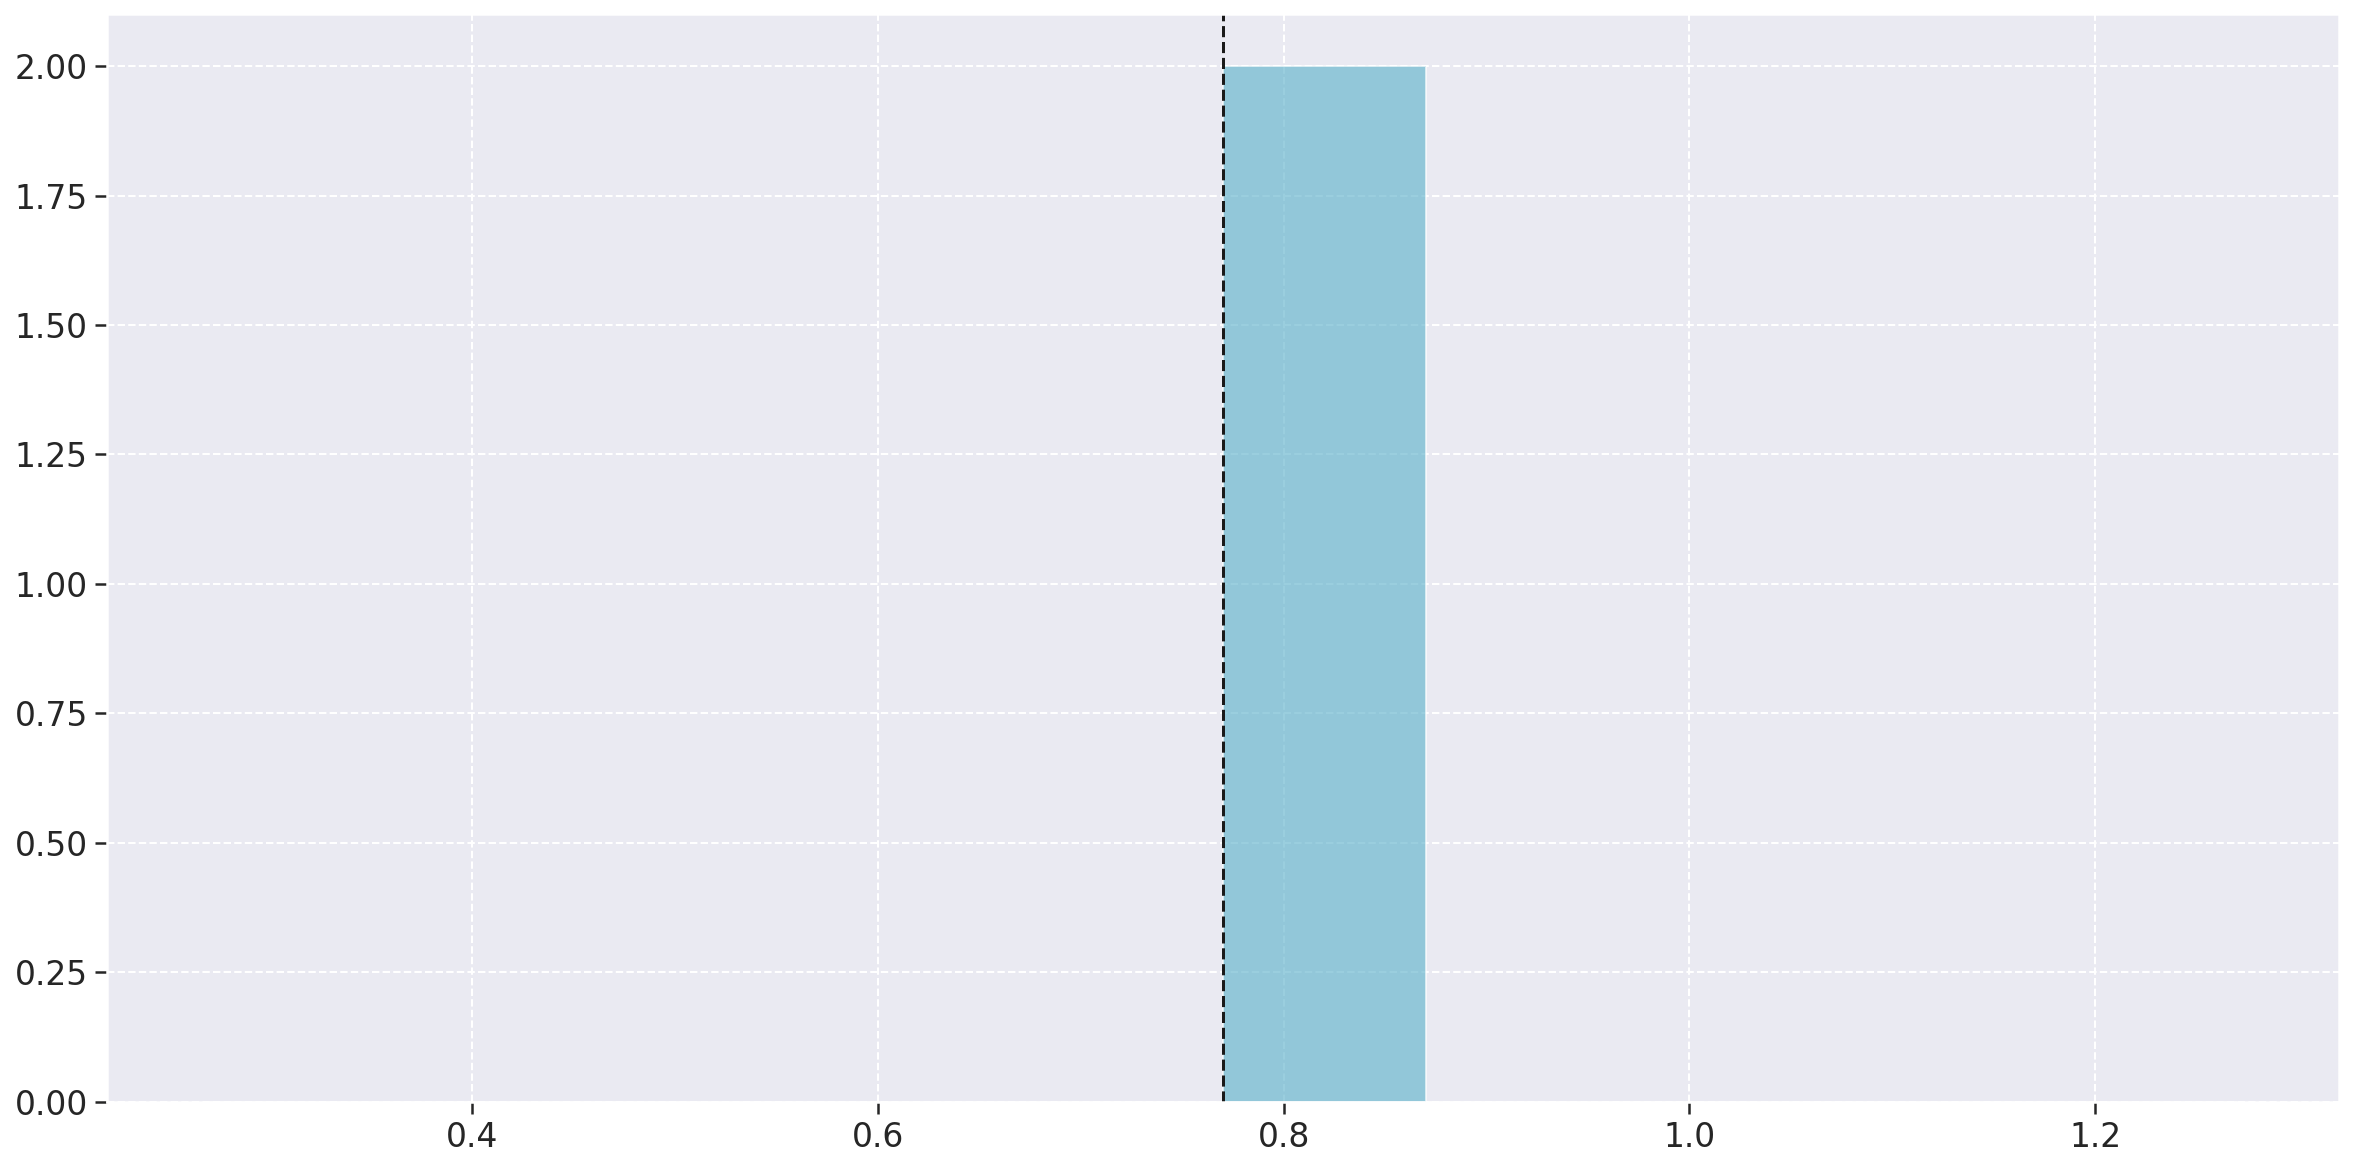

In [43]:
fig = plt.figure(figsize=(20, 10))

plt.hist(archives_metrics['code_quality'], bins=10, color='c', alpha=0.65)
plt.axvline(archives_metrics['code_quality'].mean(), color='k', linestyle='dashed')

### Testing Status

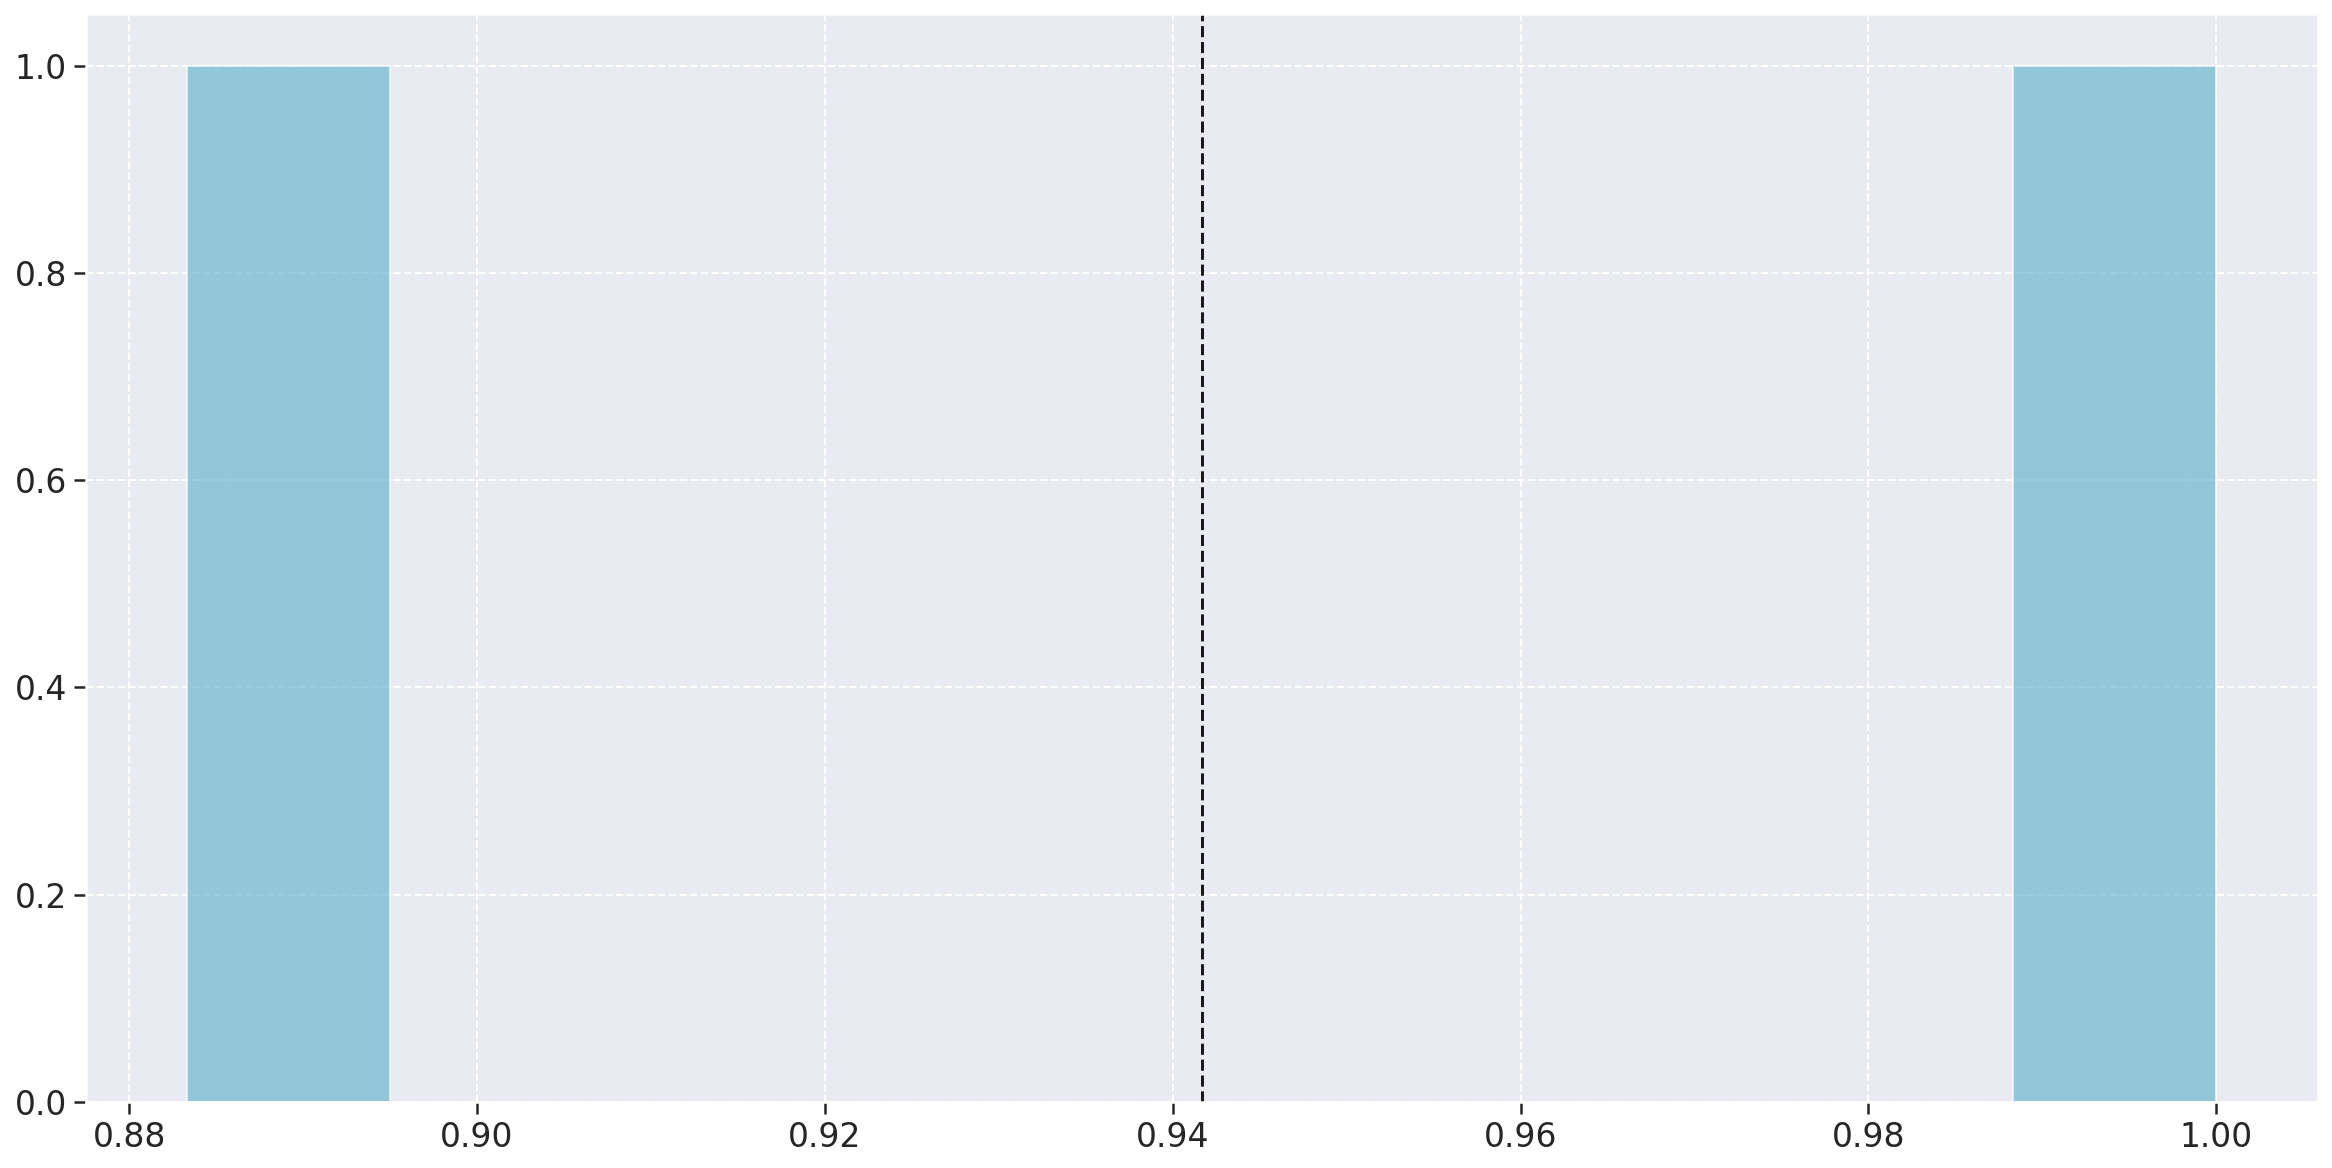

In [44]:
fig = plt.figure(figsize=(20, 10))

plt.hist(archives_metrics['testing_status'], bins=10, color='c', alpha=0.65)
plt.axvline(archives_metrics['testing_status'].mean(), color='k', linestyle='dashed')

## Boxplot

### Code Quality

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe5601bfa58>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe56014e048>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe5601bf9b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe56014e5f8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe56014e8d0>],
 'means': []}

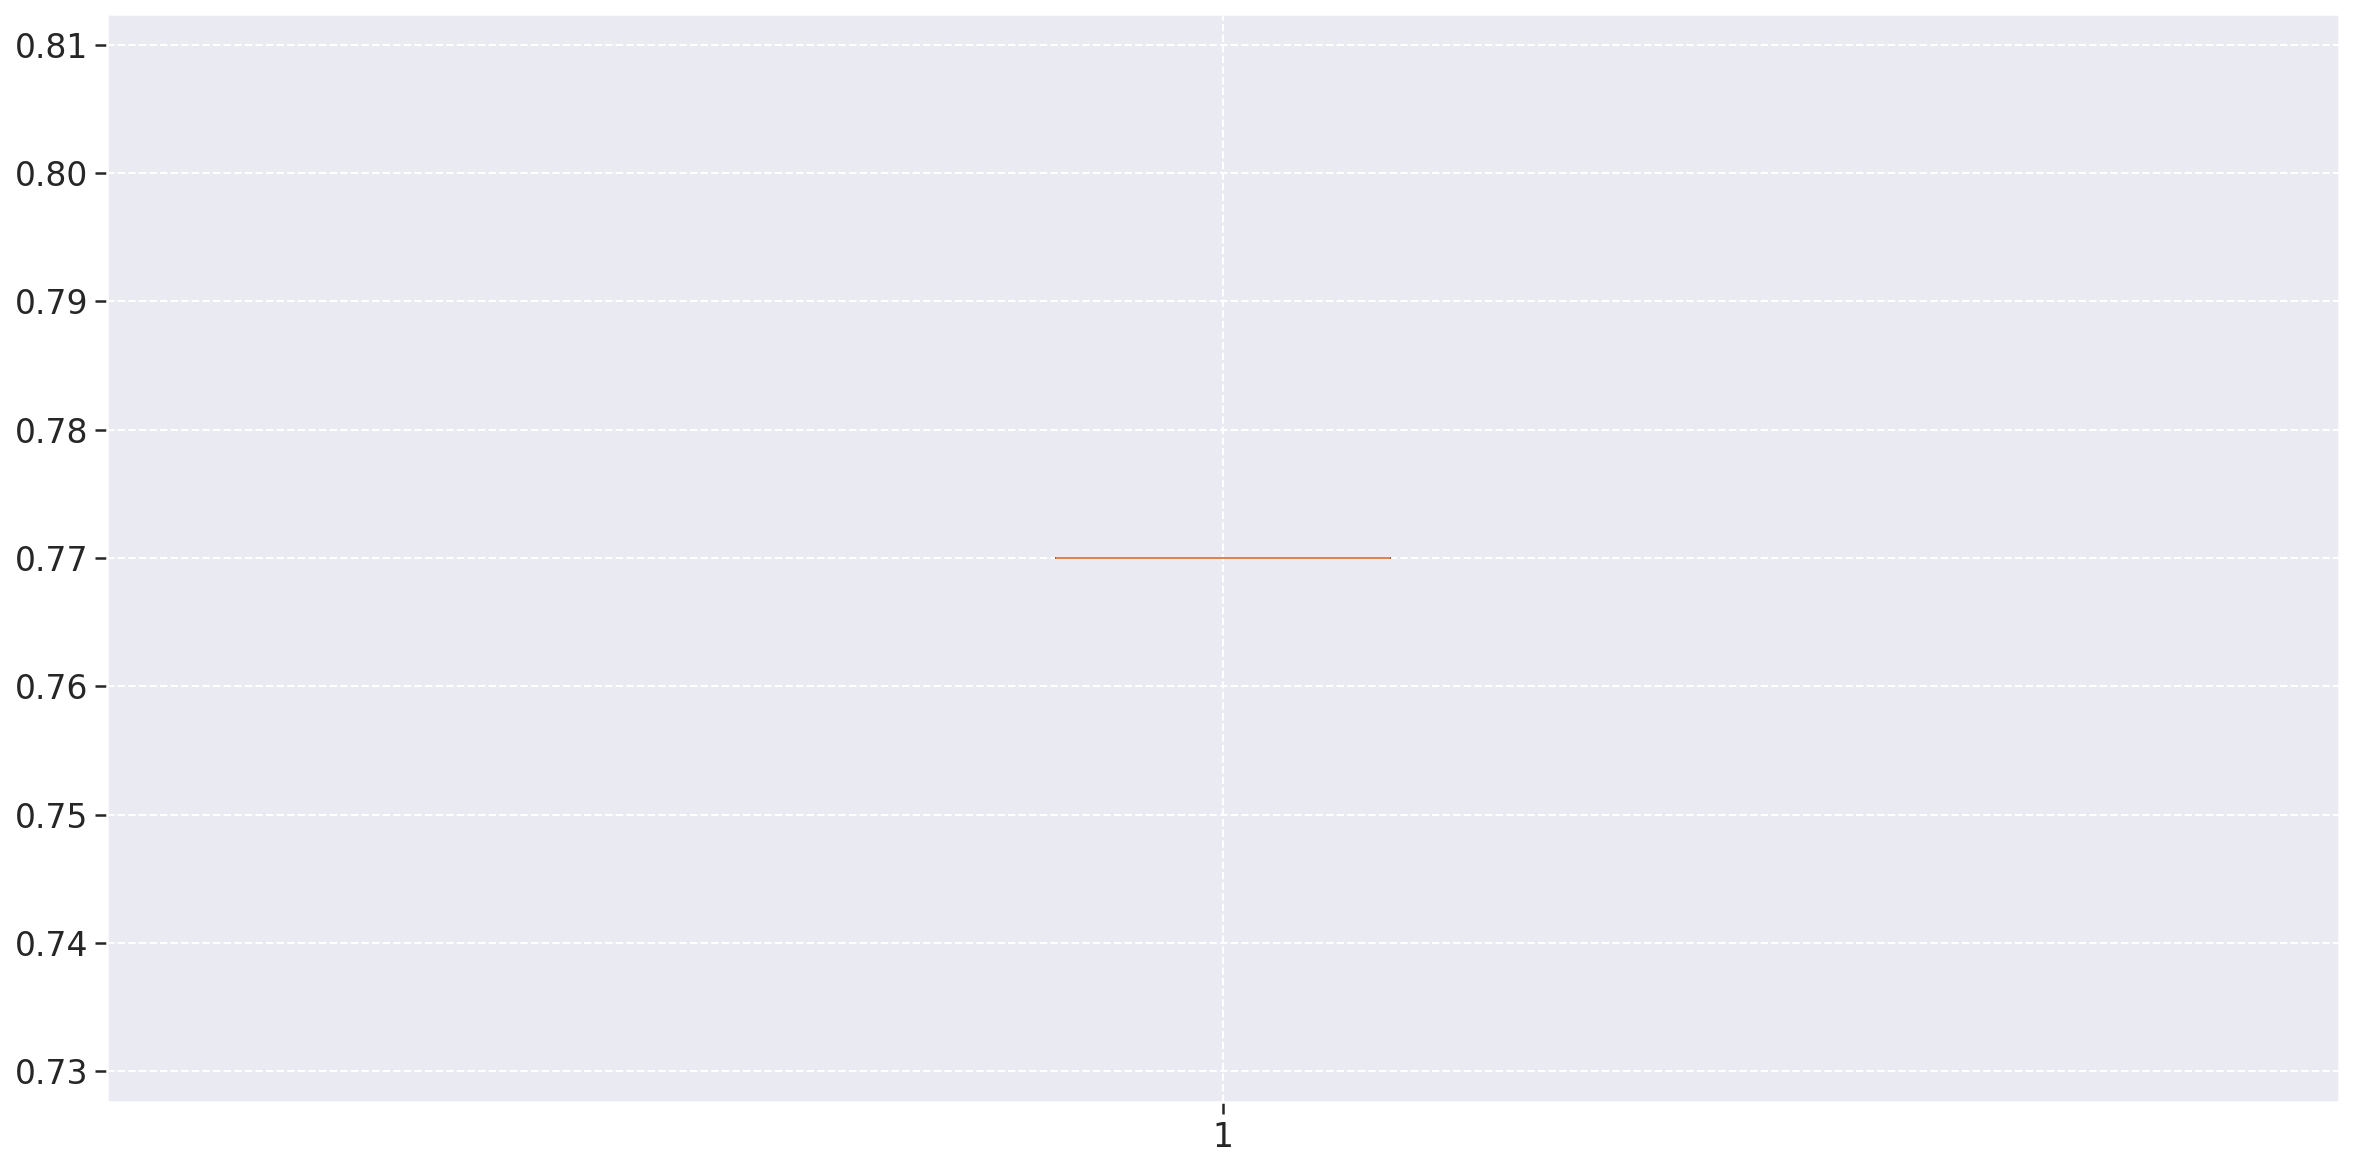

In [52]:
fig = plt.figure(figsize=(20, 10))

plt.boxplot(archives_metrics['code_quality'])

### Testing Status

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe56012fef0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe56013c4e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe56012fe48>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe56013ca90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe56013cd68>],
 'means': []}

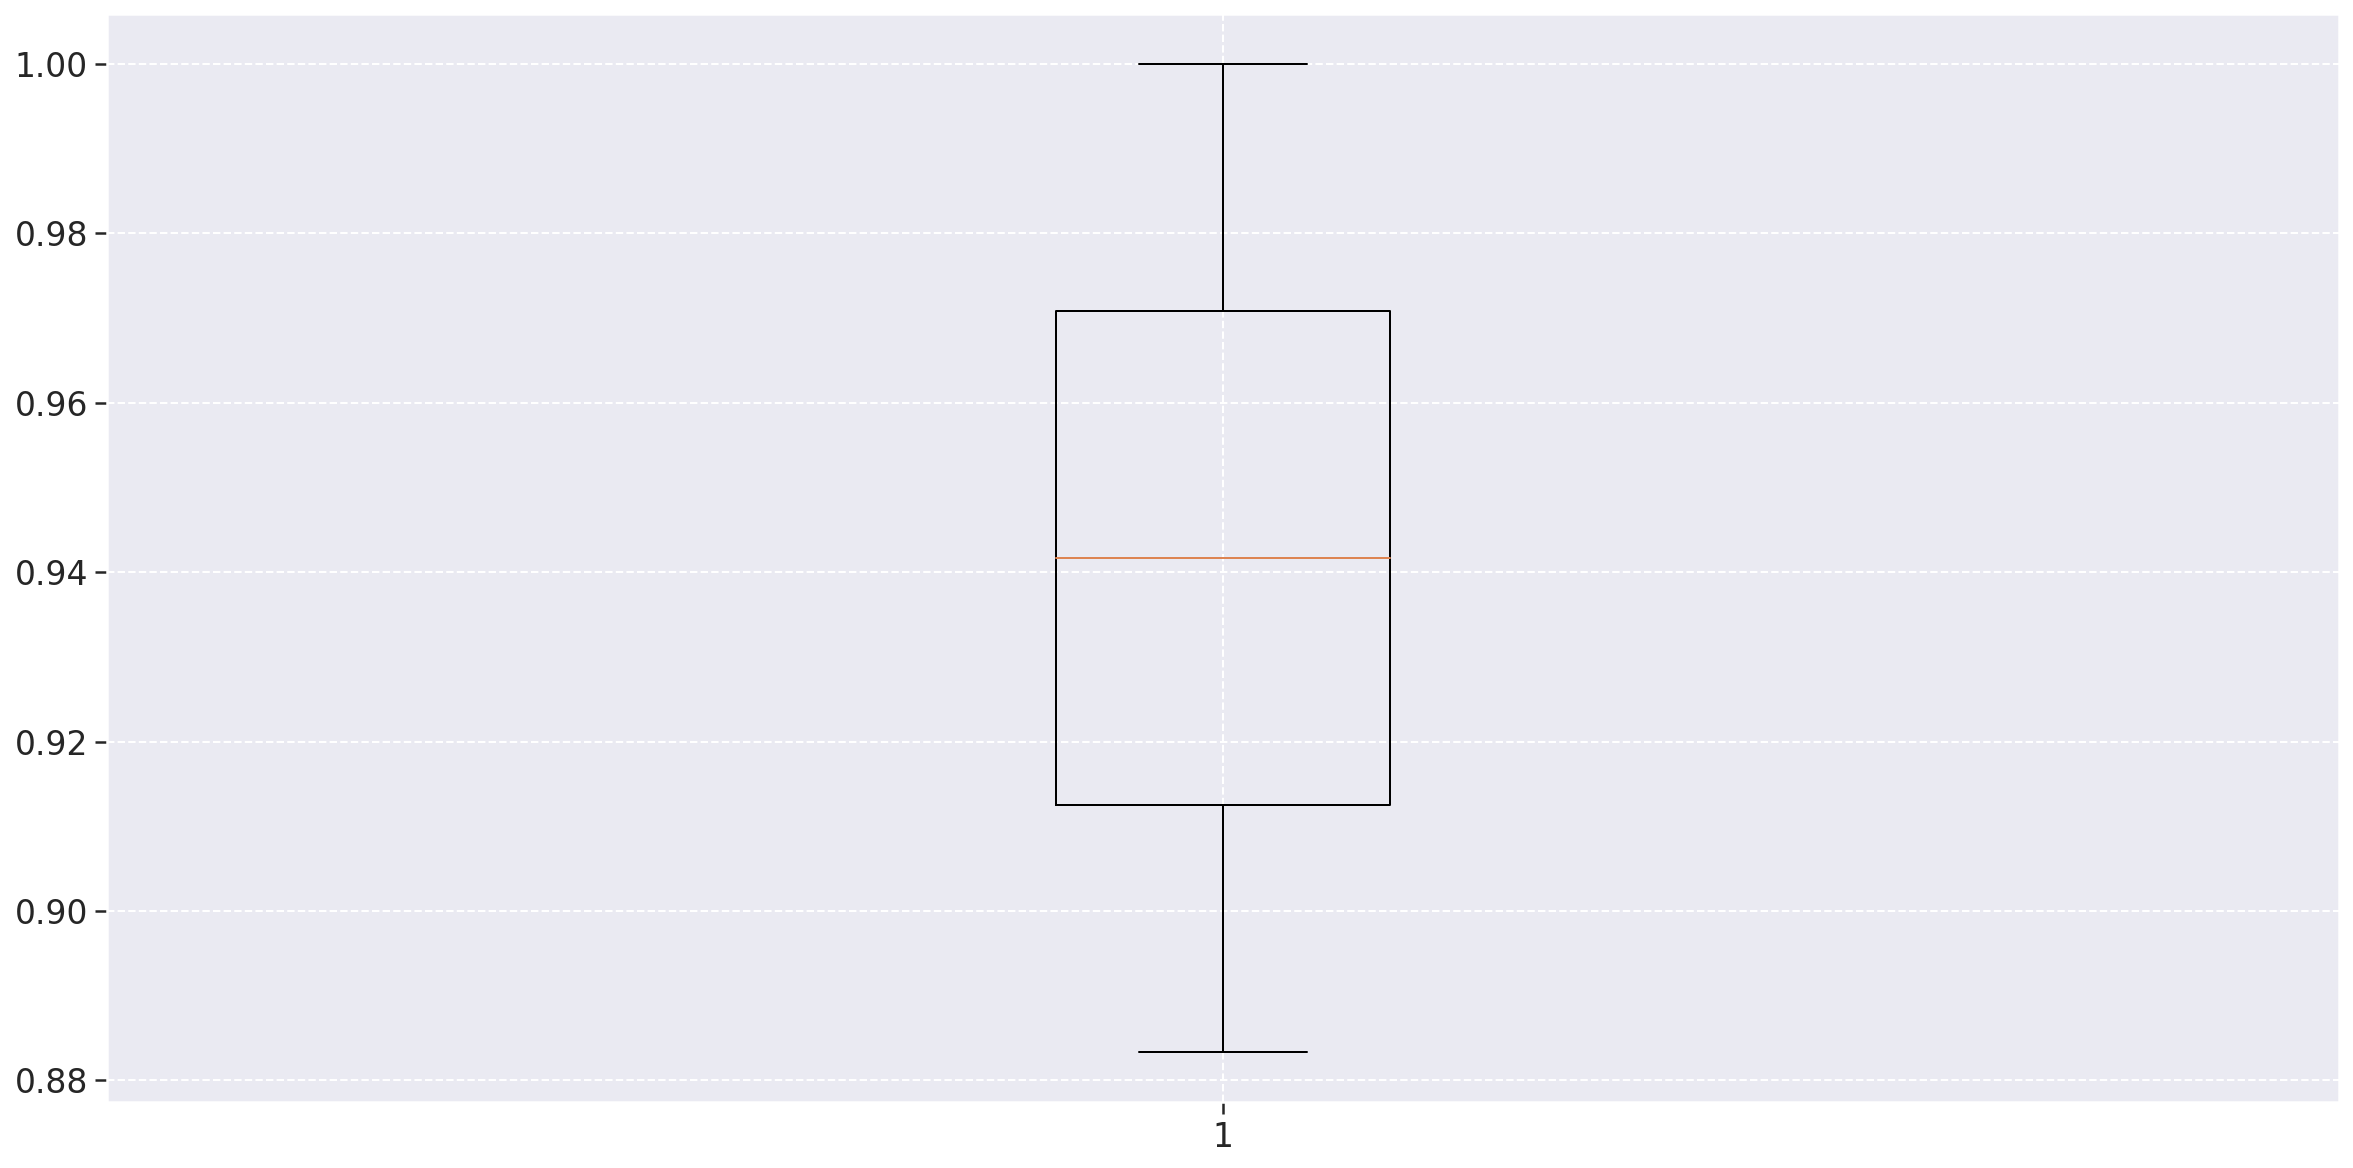

In [54]:
fig = plt.figure(figsize=(20, 10))

plt.boxplot(archives_metrics['testing_status'])

# Profile

## Histograms

### Code Quality

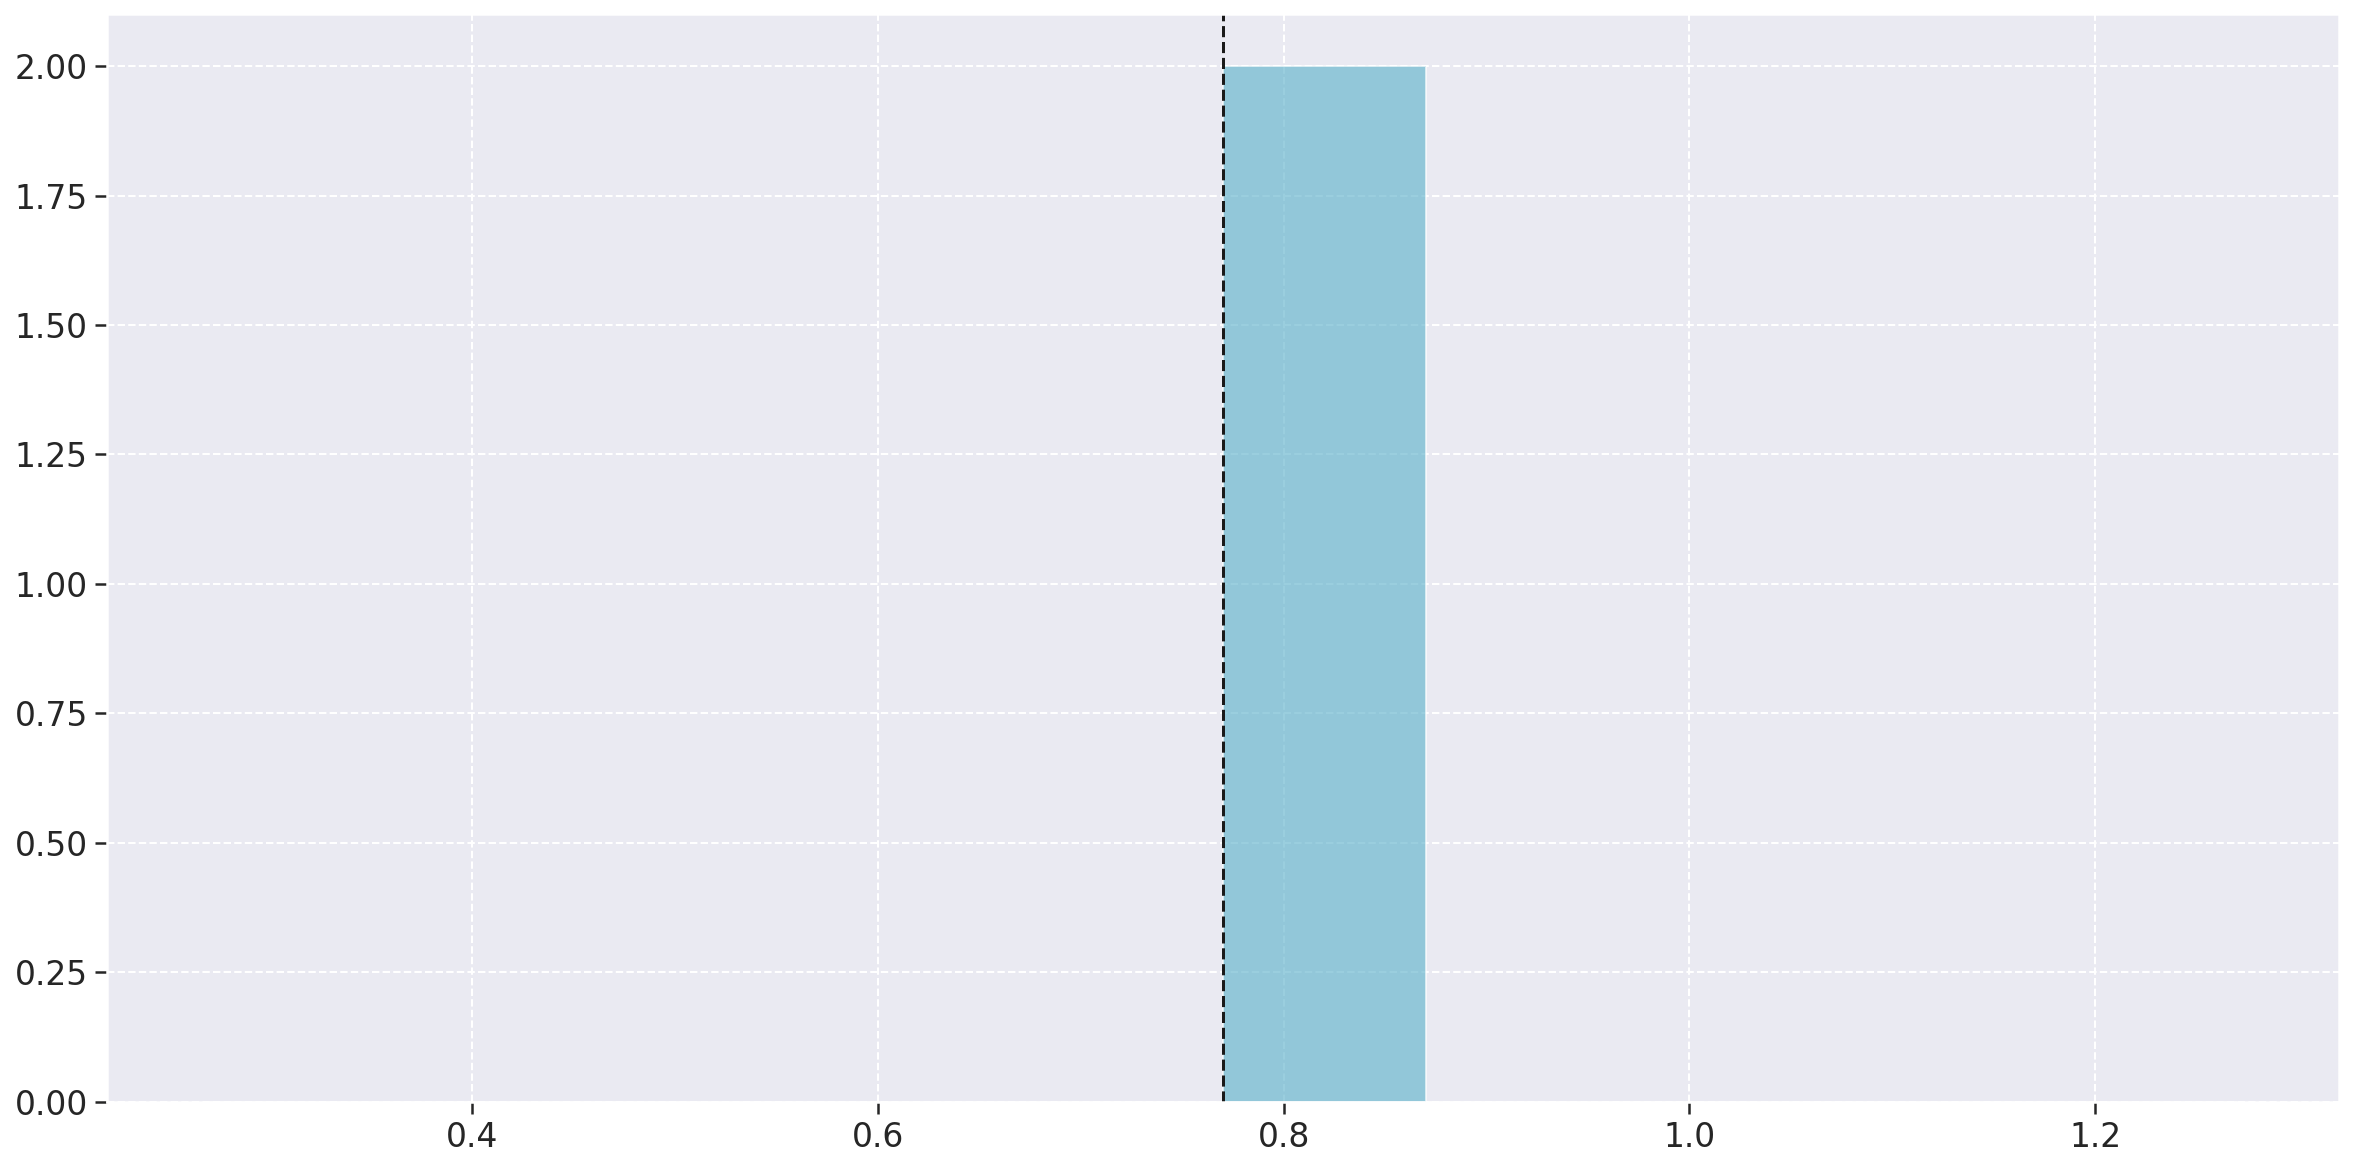

In [59]:
fig = plt.figure(figsize=(20, 10))

plt.hist(profile_metrics['code_quality'], bins=10, color='c', alpha=0.65)
plt.axvline(profile_metrics['code_quality'].mean(), color='k', linestyle='dashed')

### Testing Status

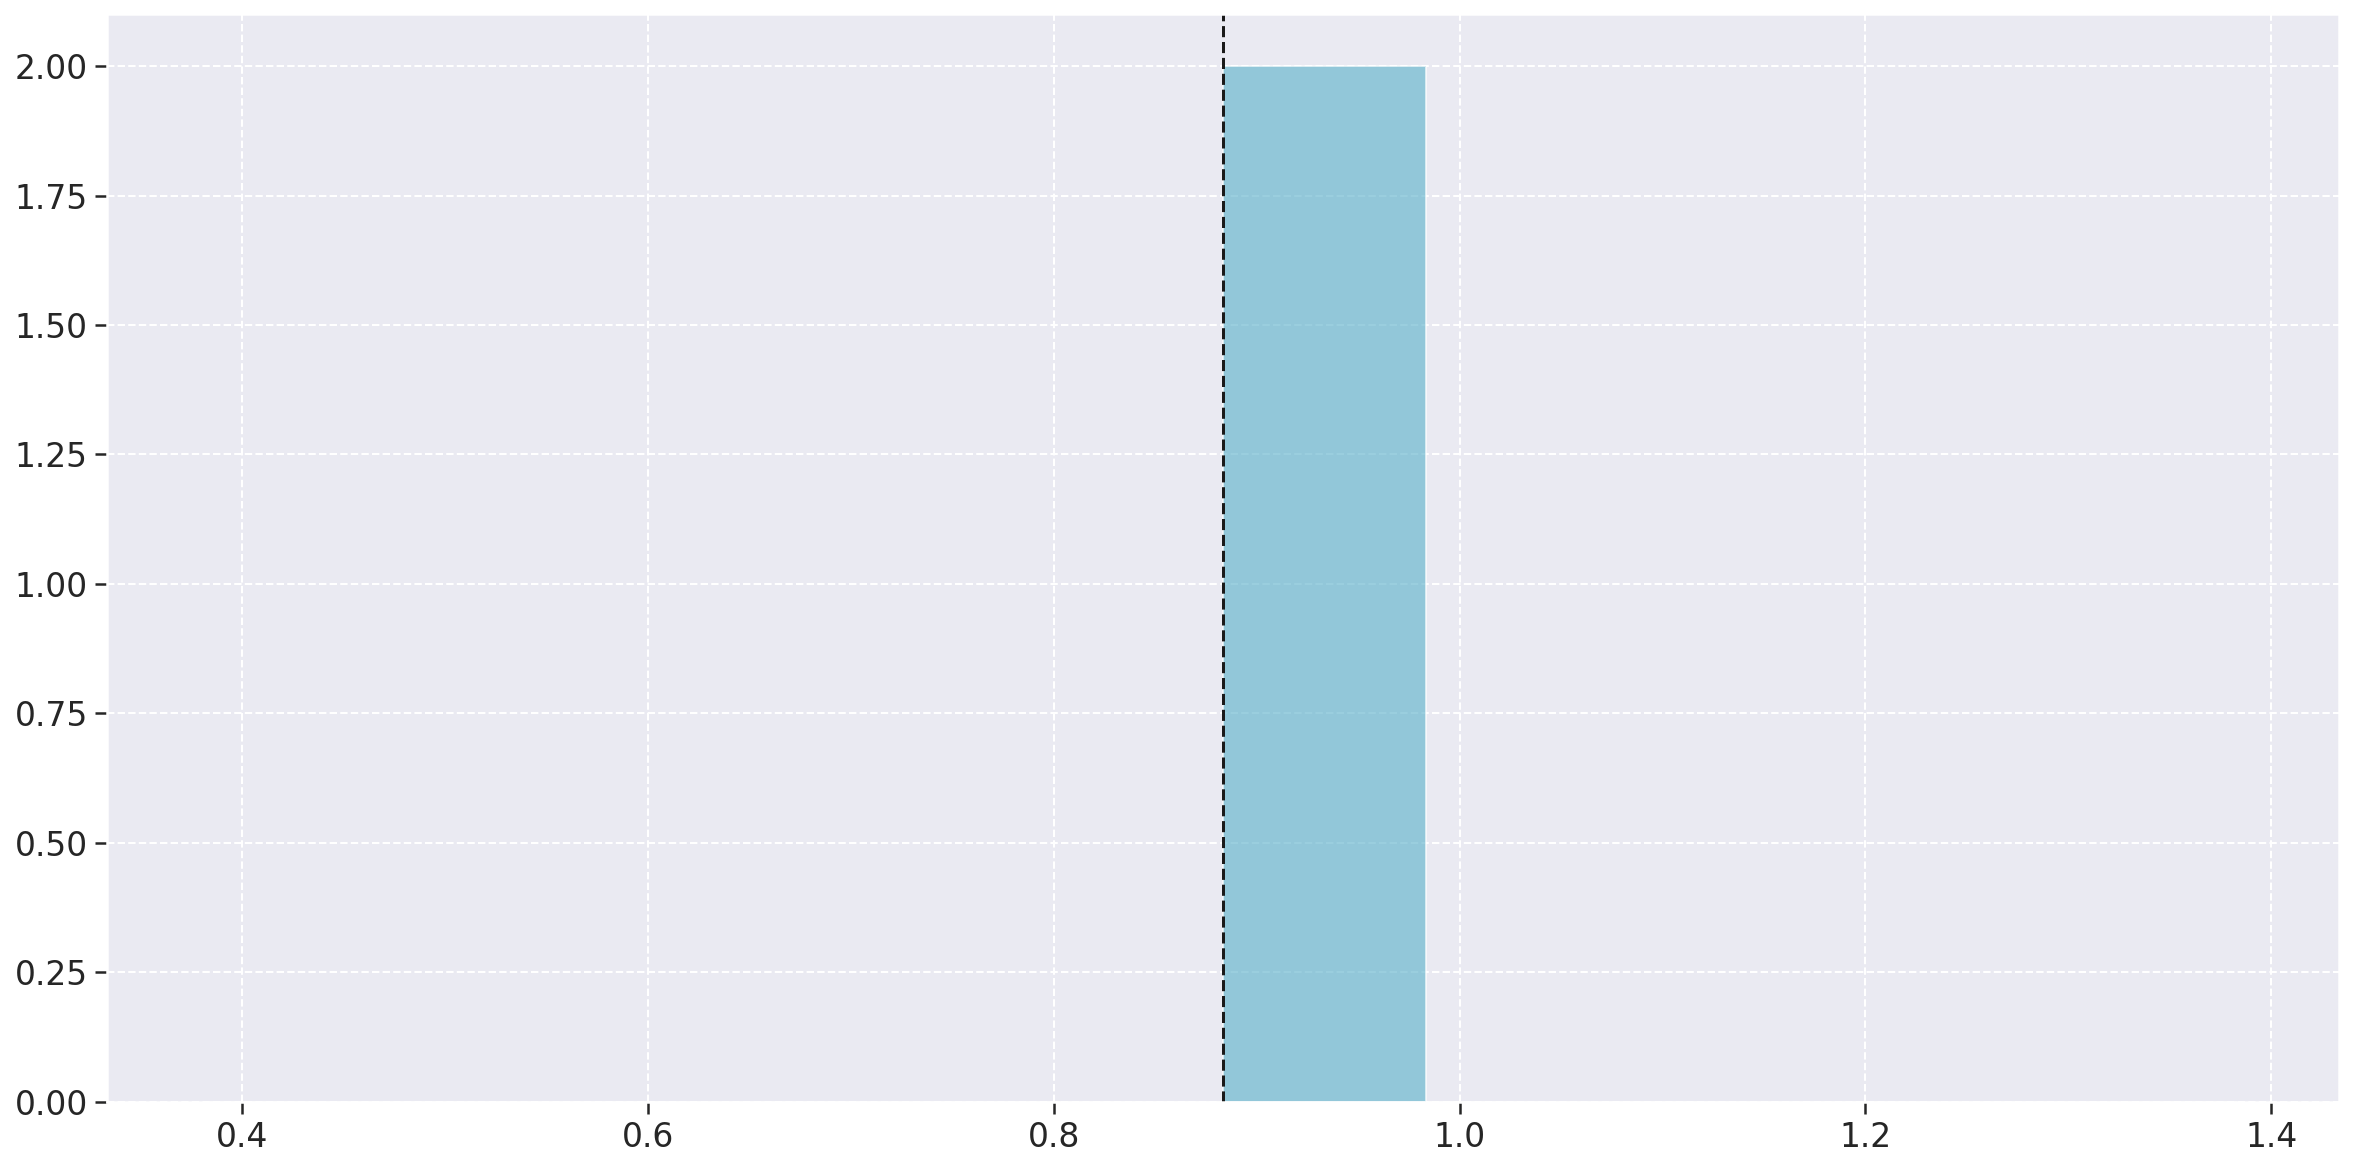

In [60]:
fig = plt.figure(figsize=(20, 10))

plt.hist(profile_metrics['testing_status'], bins=10, color='c', alpha=0.65)
plt.axvline(profile_metrics['testing_status'].mean(), color='k', linestyle='dashed')

## Boxplot

### Code Quality

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe5600178d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe560017e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe560017828>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe560024470>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe560024748>],
 'means': []}

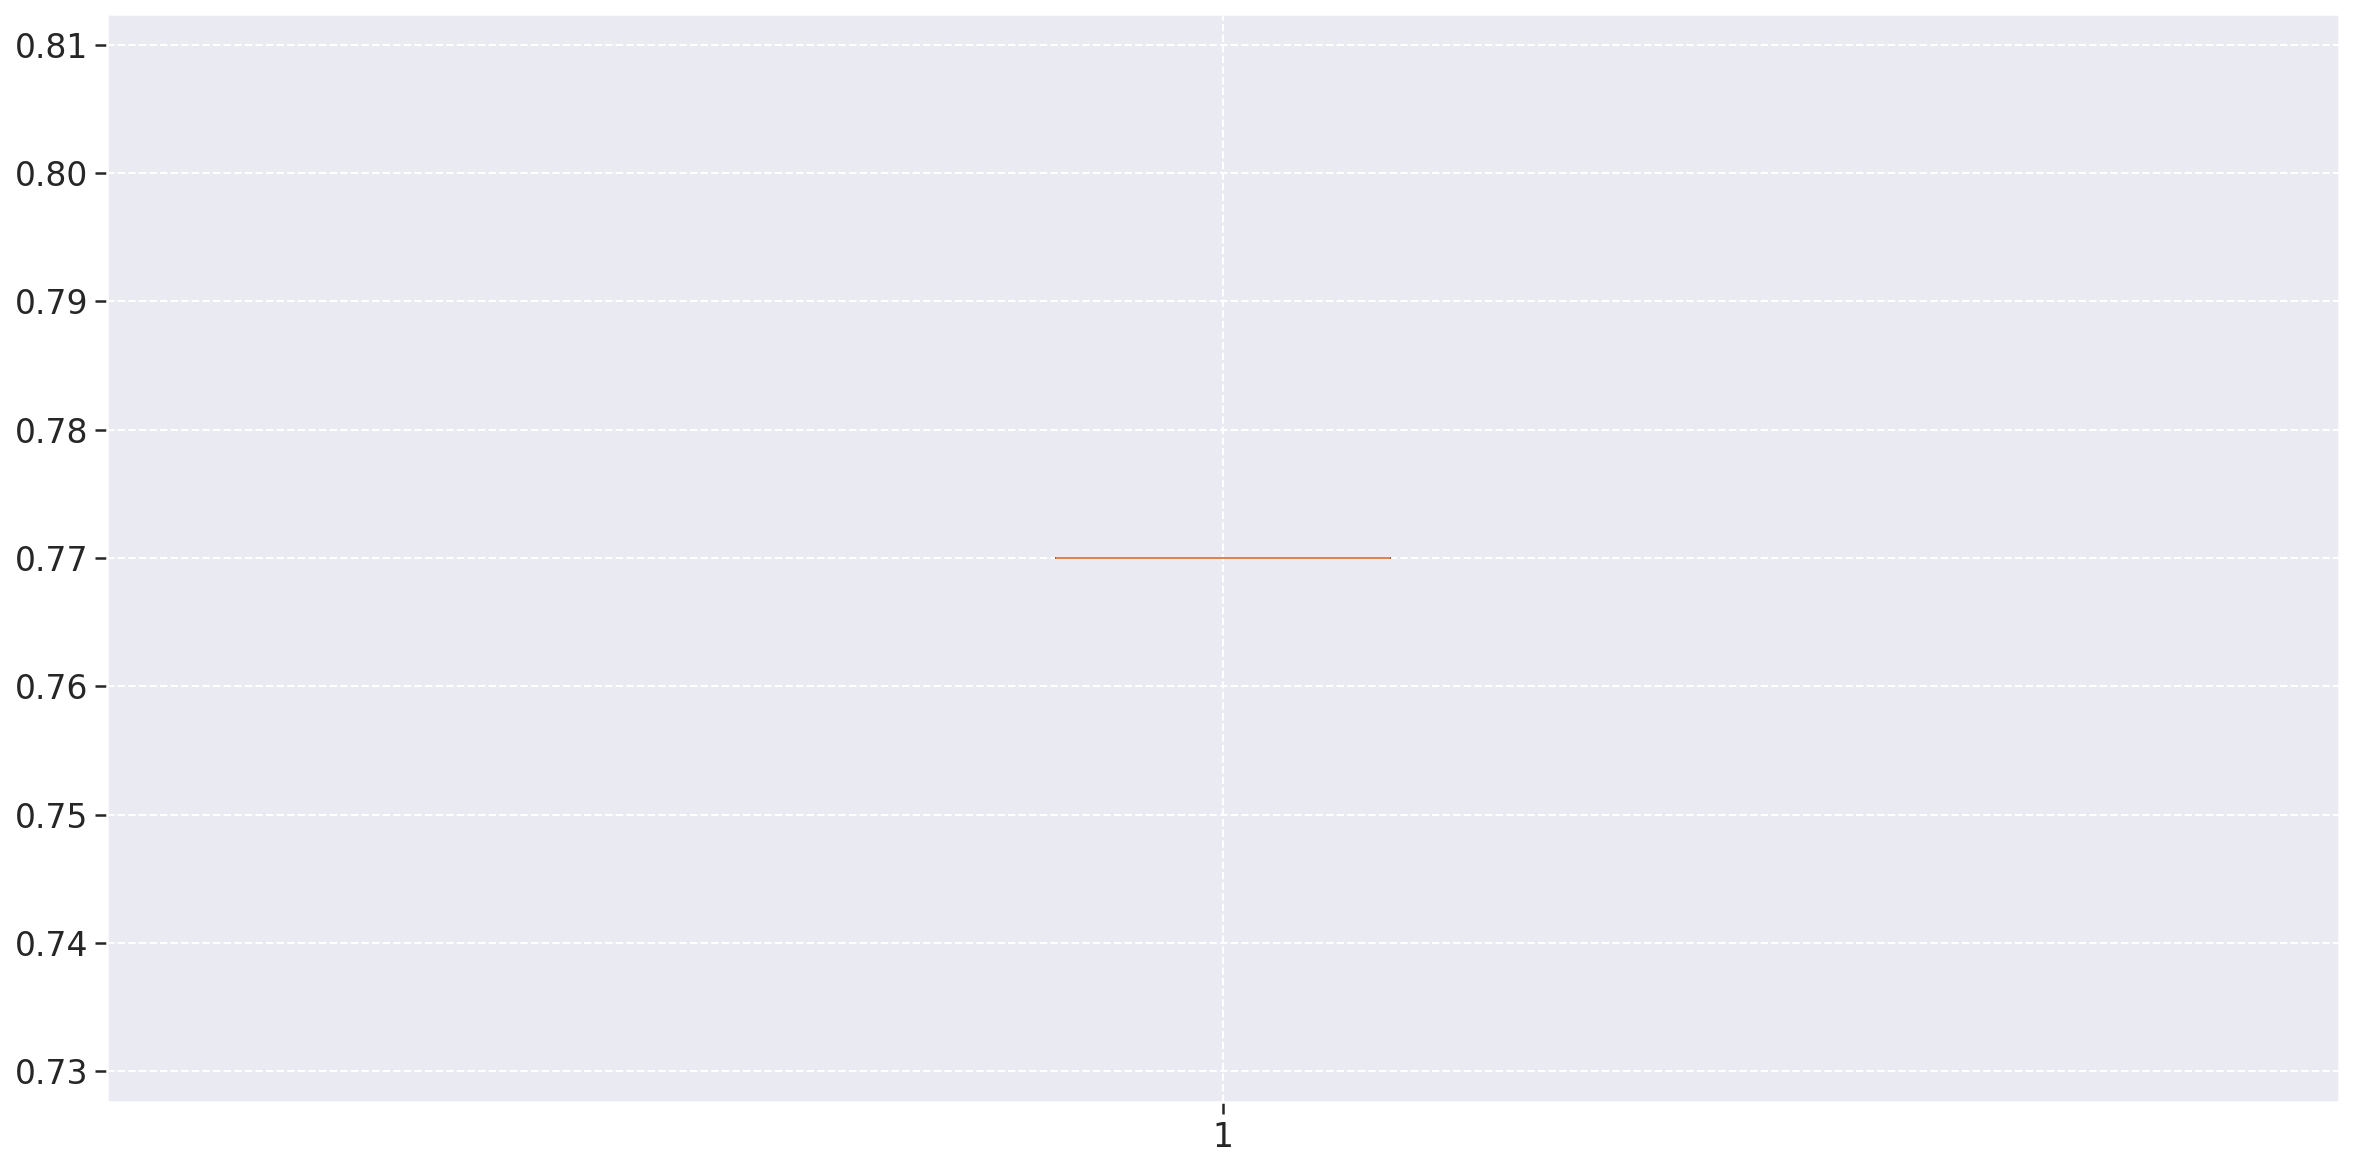

In [56]:
fig = plt.figure(figsize=(20, 10))

plt.boxplot(profile_metrics['code_quality'])

### Testing Status

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe55b782cf8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe55b7912e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe55b782c50>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe55b791898>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe55b791b70>],
 'means': []}

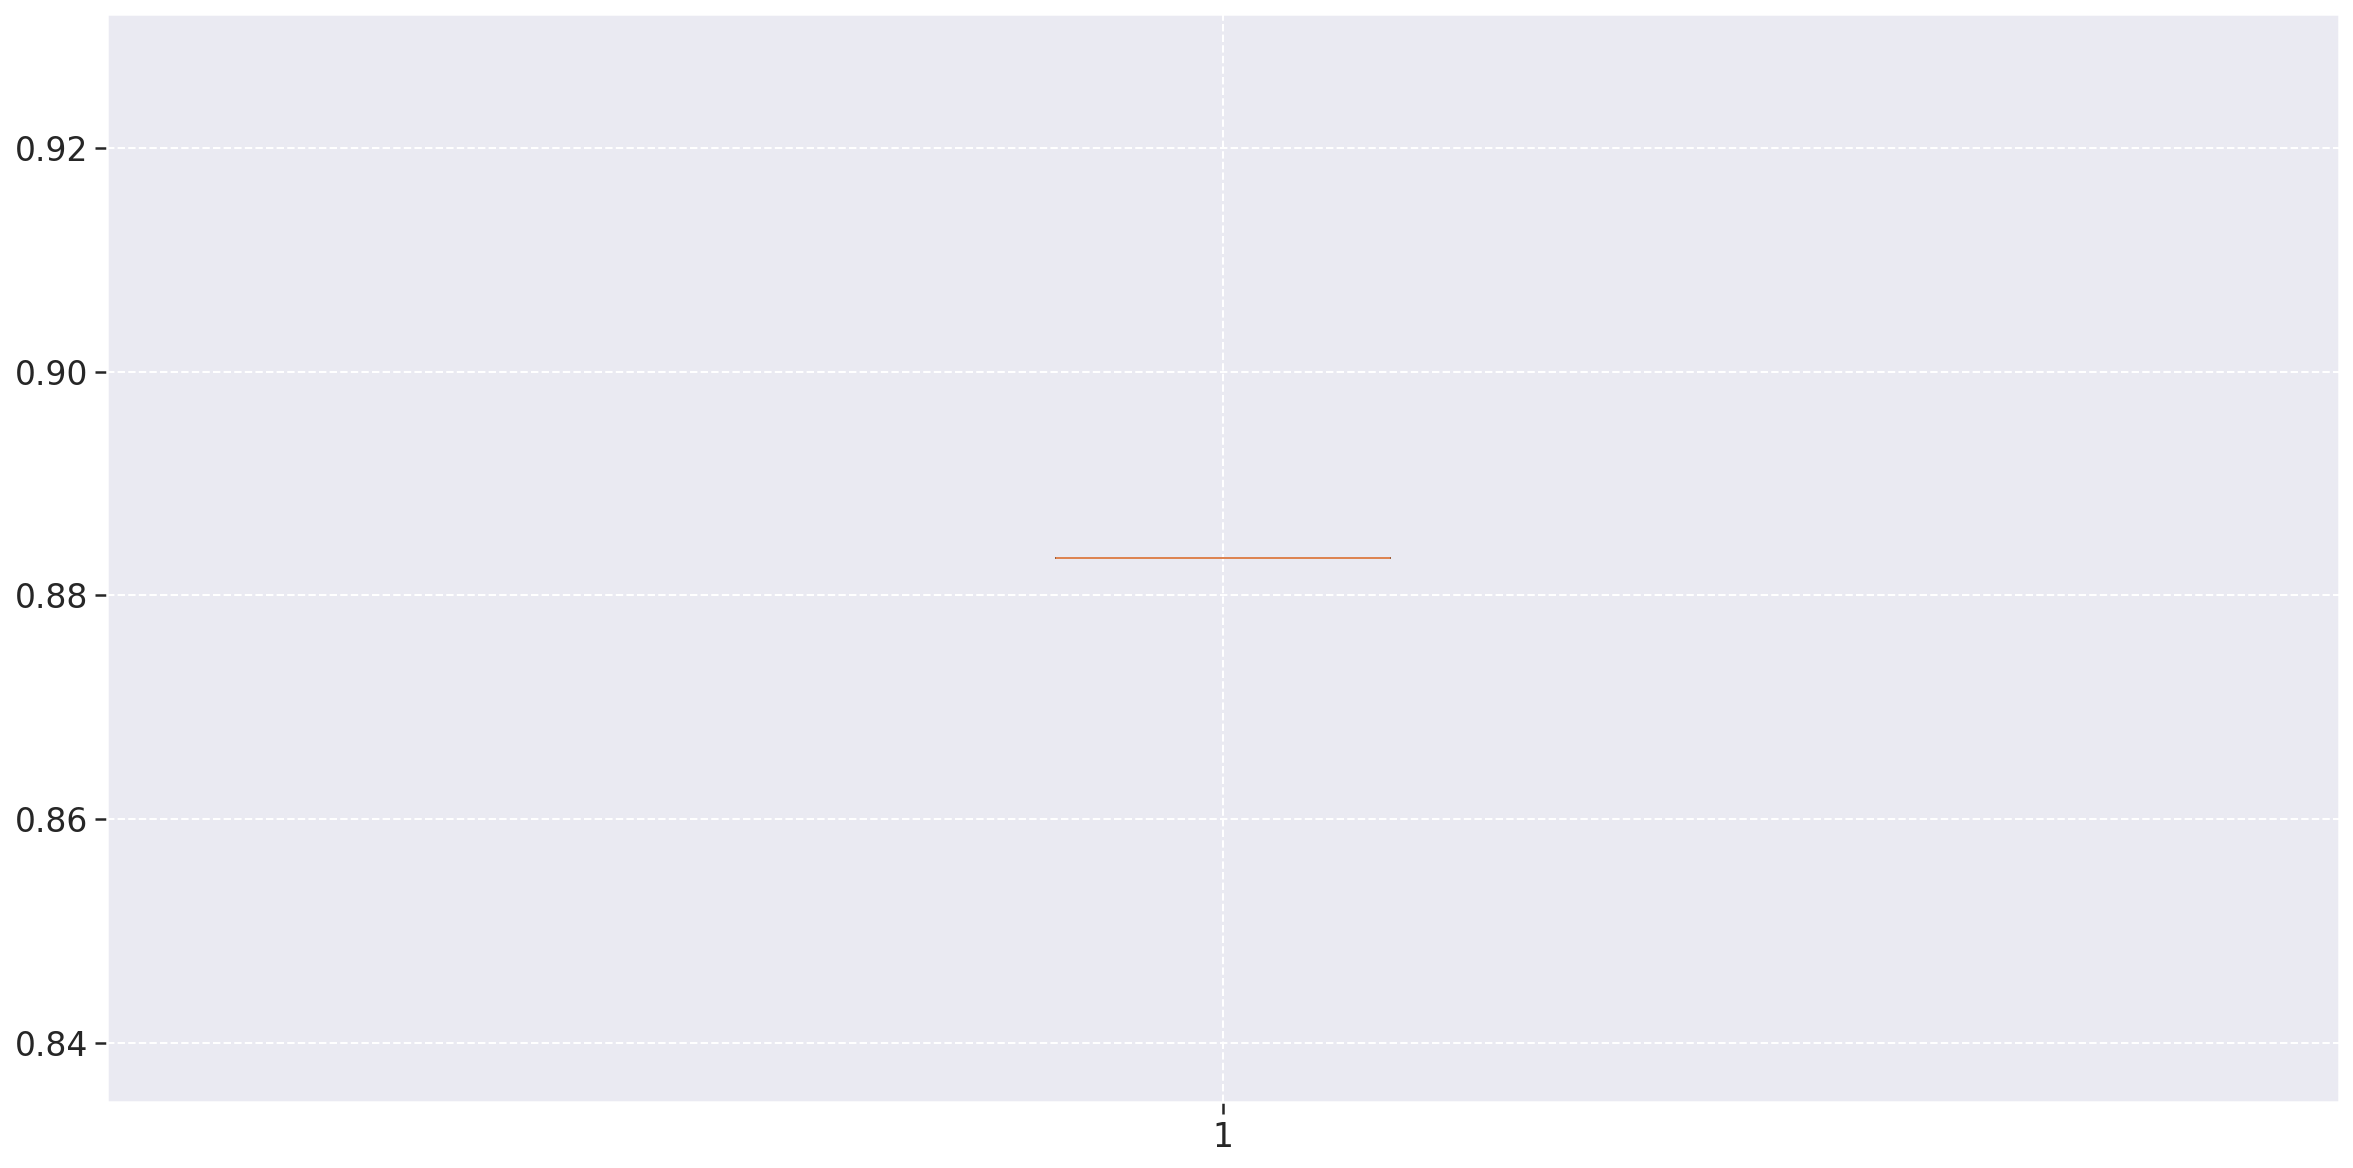

In [57]:
fig = plt.figure(figsize=(20, 10))

plt.boxplot(profile_metrics['testing_status'])

## Analysis

### Code Quality

We can see at the **histogram** (only has one column) and **boxplot** (a single line boxplot) graphs that both of the releases, R1 and MVP, have the same code quality value, so it's safe to assume that the new code hasn't affected the code quality at all.

### Testing Status

Just like the metric above, the testing status metric hasn't changed at all at the **histogram** and **boxplot** graphs.

# Frontend

## Histograms

### Code Quality

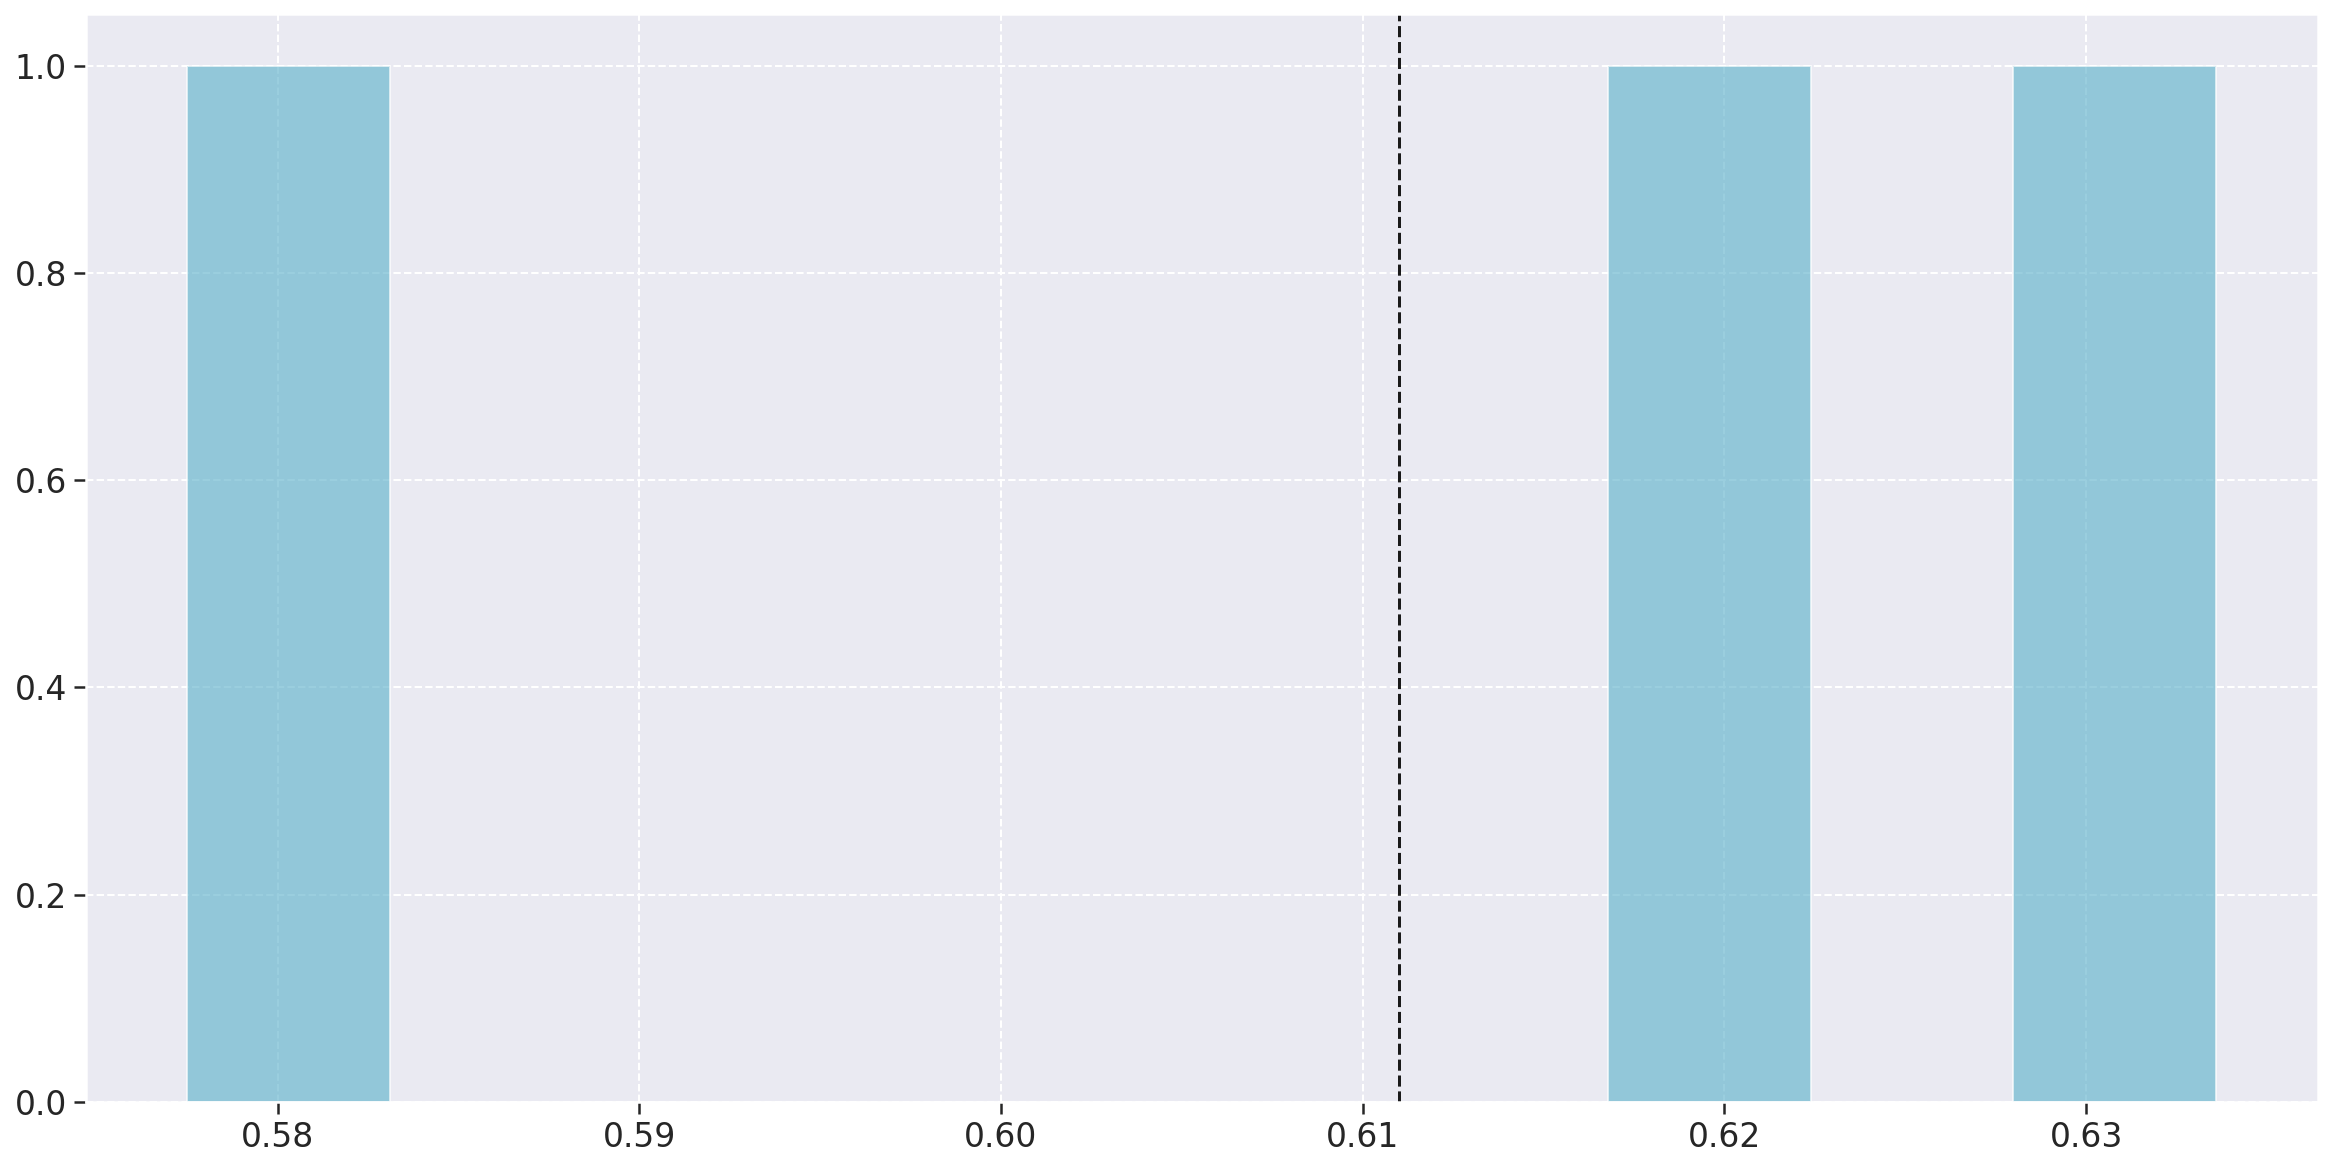

In [64]:
fig = plt.figure(figsize=(20, 10))

plt.hist(frontend_metrics['code_quality'], bins=10, color='c', alpha=0.65)
plt.axvline(frontend_metrics['code_quality'].mean(), color='k', linestyle='dashed')

### Testing Status

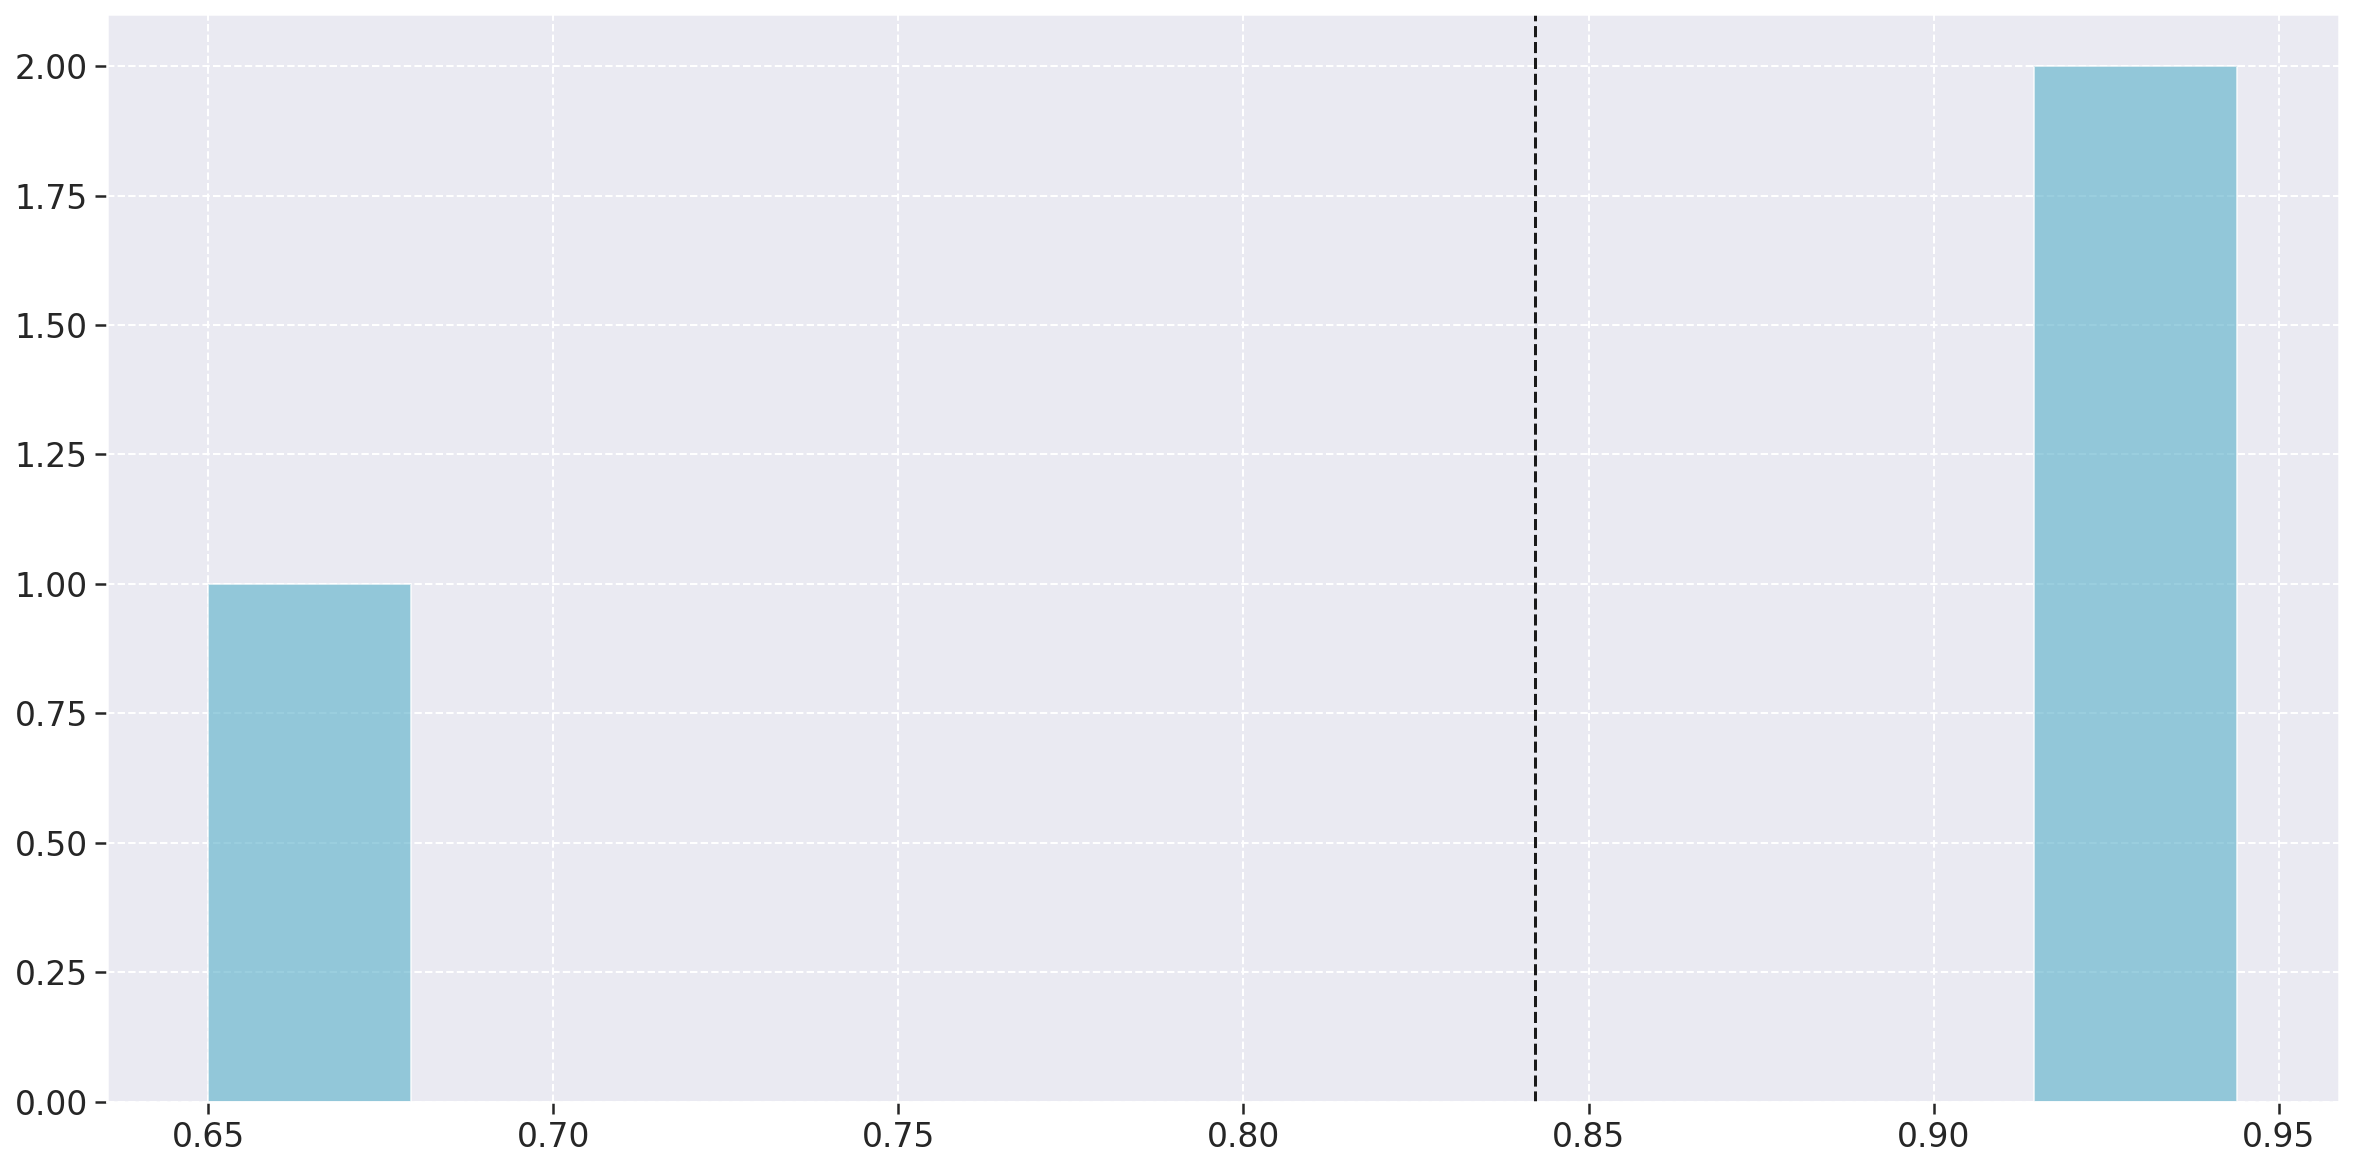

In [63]:
fig = plt.figure(figsize=(20, 10))

plt.hist(frontend_metrics['testing_status'], bins=10, color='c', alpha=0.65)
plt.axvline(frontend_metrics['testing_status'].mean(), color='k', linestyle='dashed')

## Boxplot

### Code Quality

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe55b7db7f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe56006d9b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe55b7dbe10>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe56006def0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe55b7de2e8>],
 'means': []}

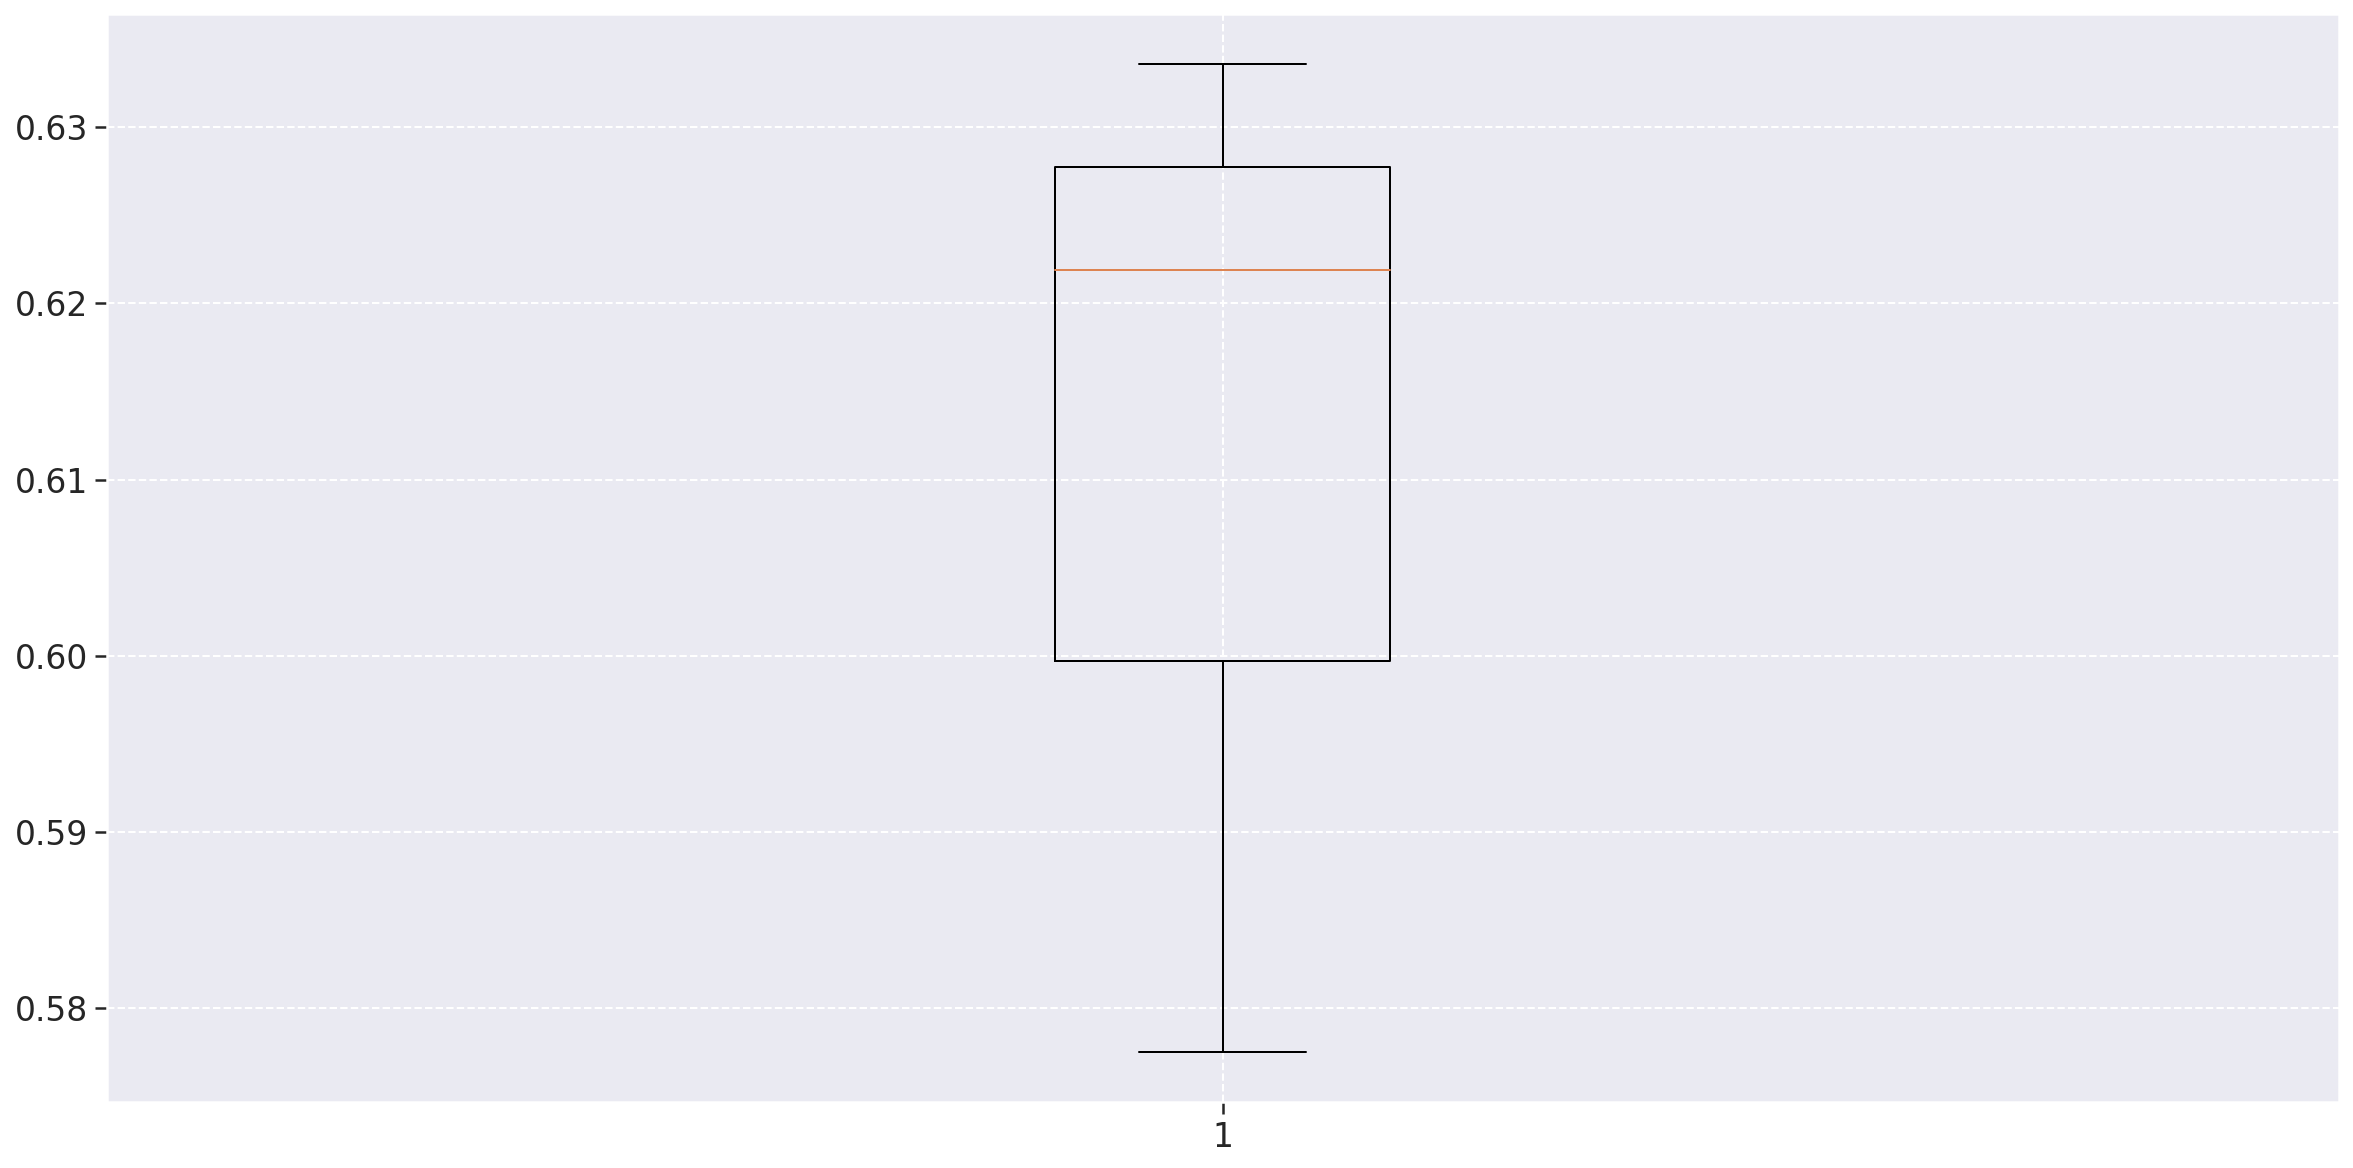

In [65]:
fig = plt.figure(figsize=(20, 10))

plt.boxplot(frontend_metrics['code_quality'])

### Testing Status

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe55b3459b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe55b345f60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe55b345908>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe55b354550>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe55b354828>],
 'means': []}

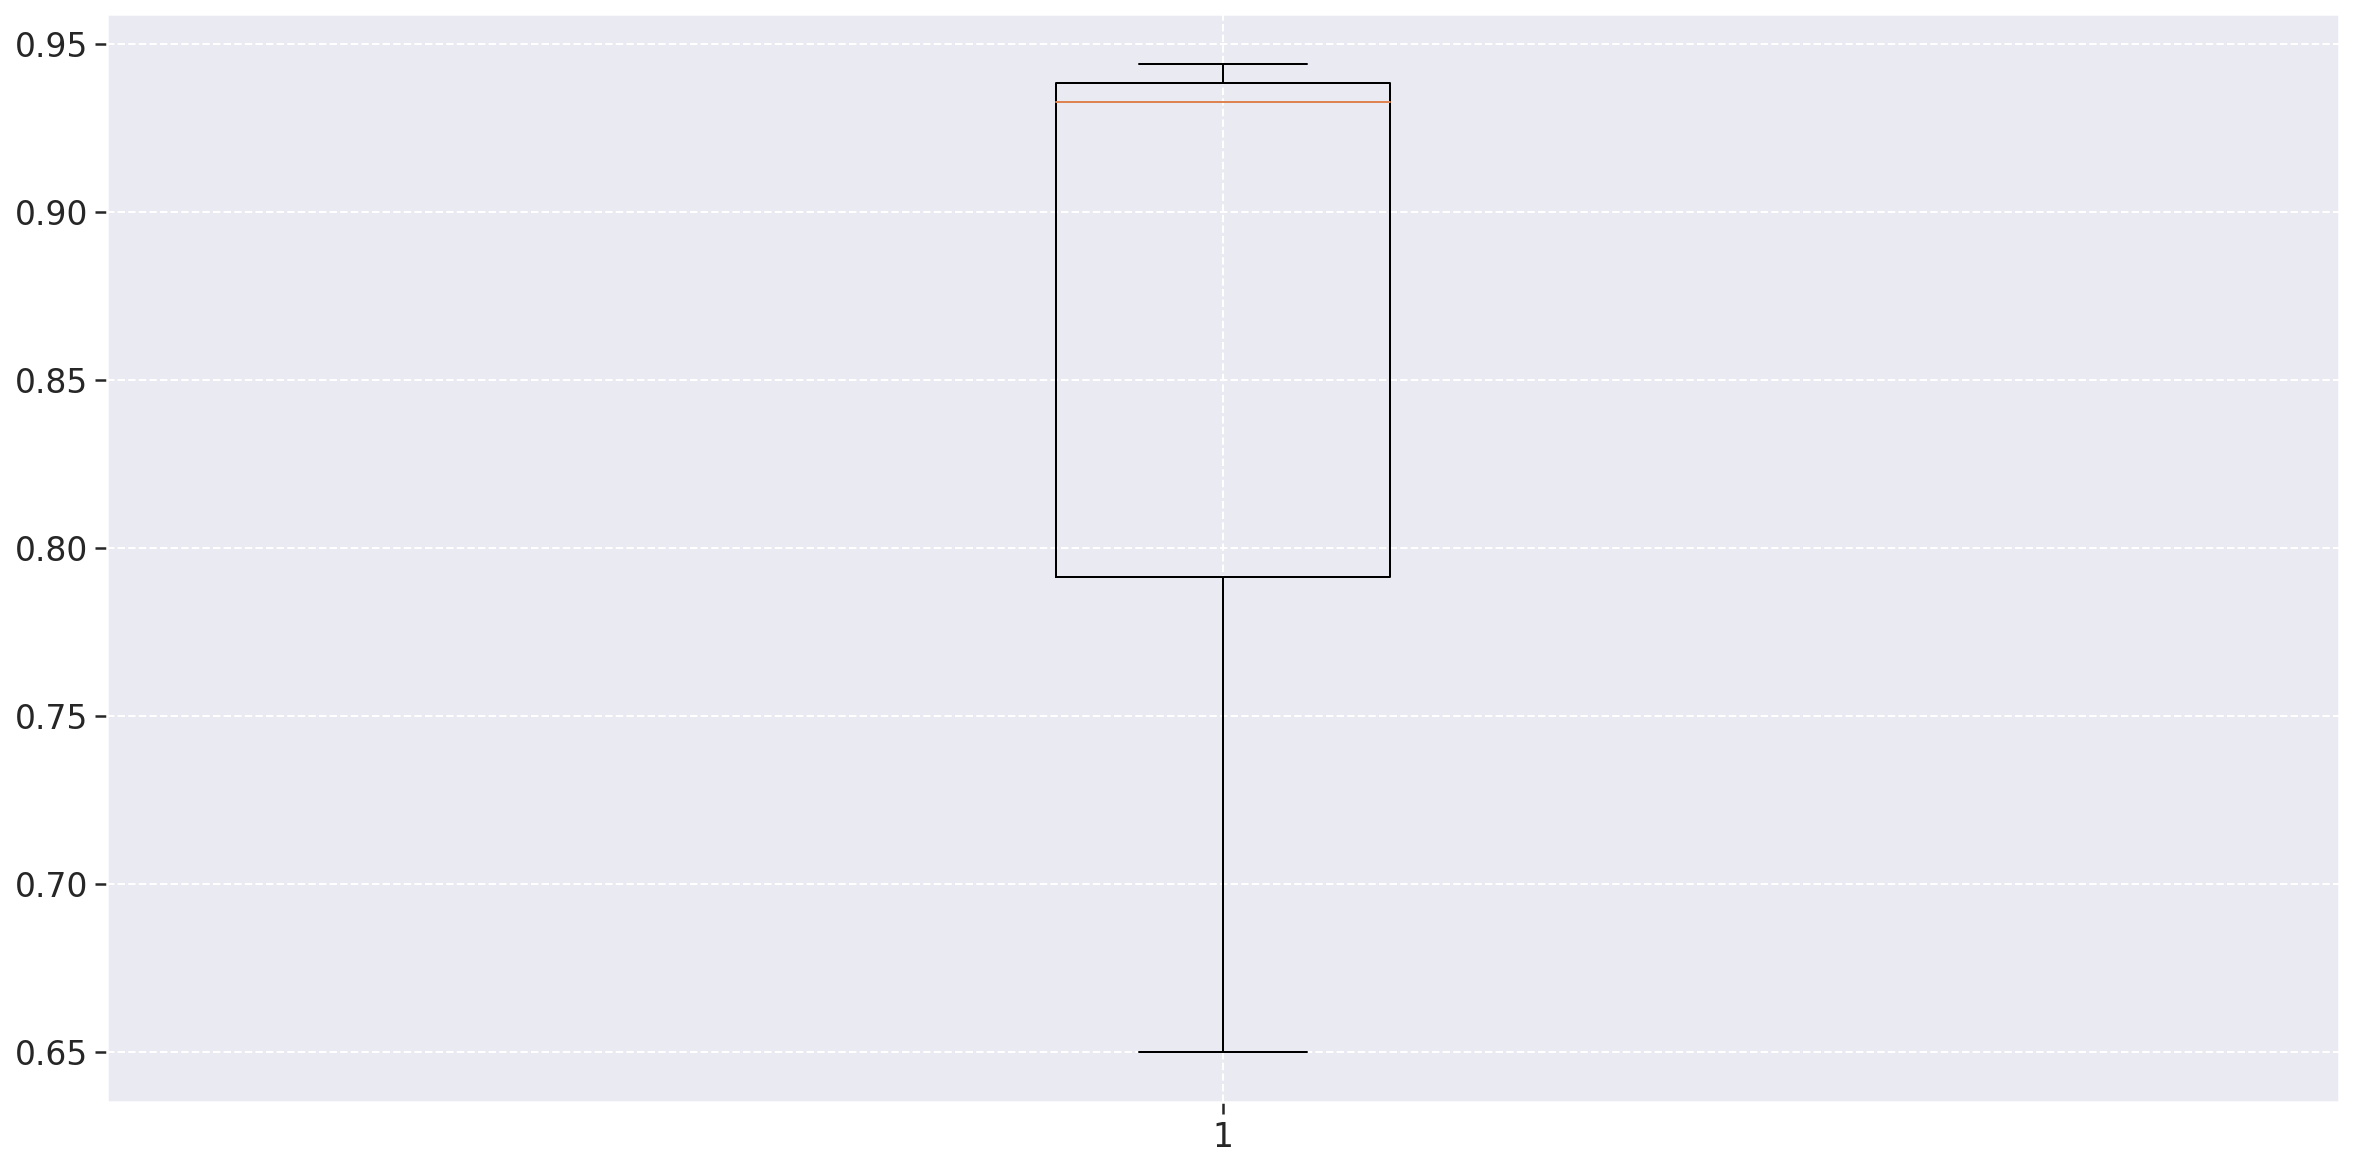

In [69]:
fig = plt.figure(figsize=(20, 10))

plt.boxplot(frontend_metrics['testing_status'])

# Total Quality Aspect

## Histogram

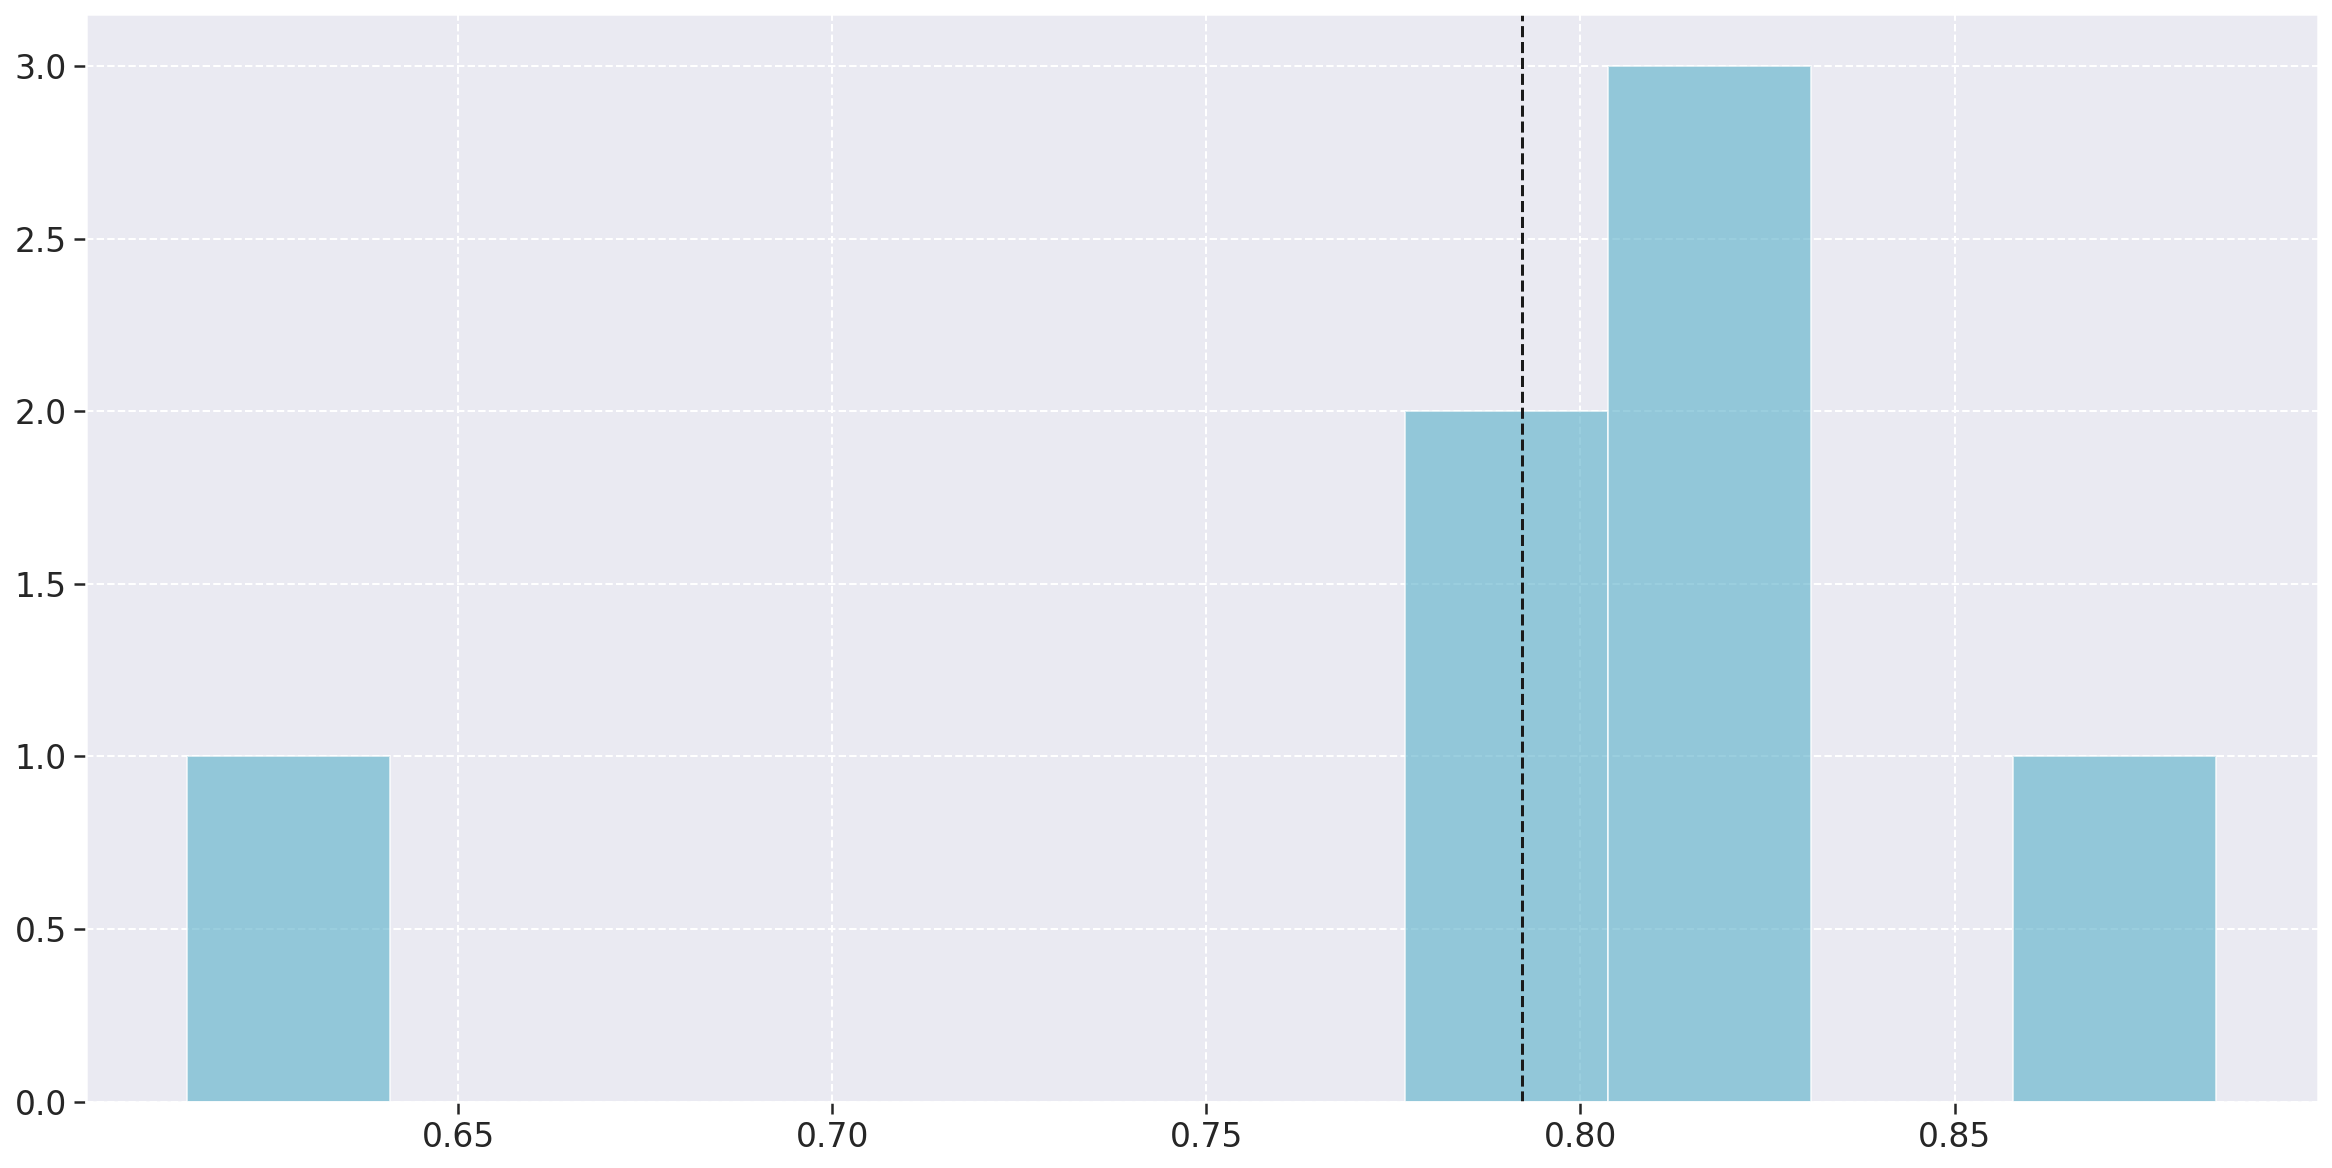

In [71]:
fig = plt.figure(figsize=(20, 10))

plt.hist(metrics_df['total'], bins=10, color='c', alpha=0.65)
plt.axvline(metrics_df['total'].mean(), color='k', linestyle='dashed')

## Boxplot

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe55b234630>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe55b234be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe55b234588>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe55b1c31d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe55b1c34a8>],
 'means': []}

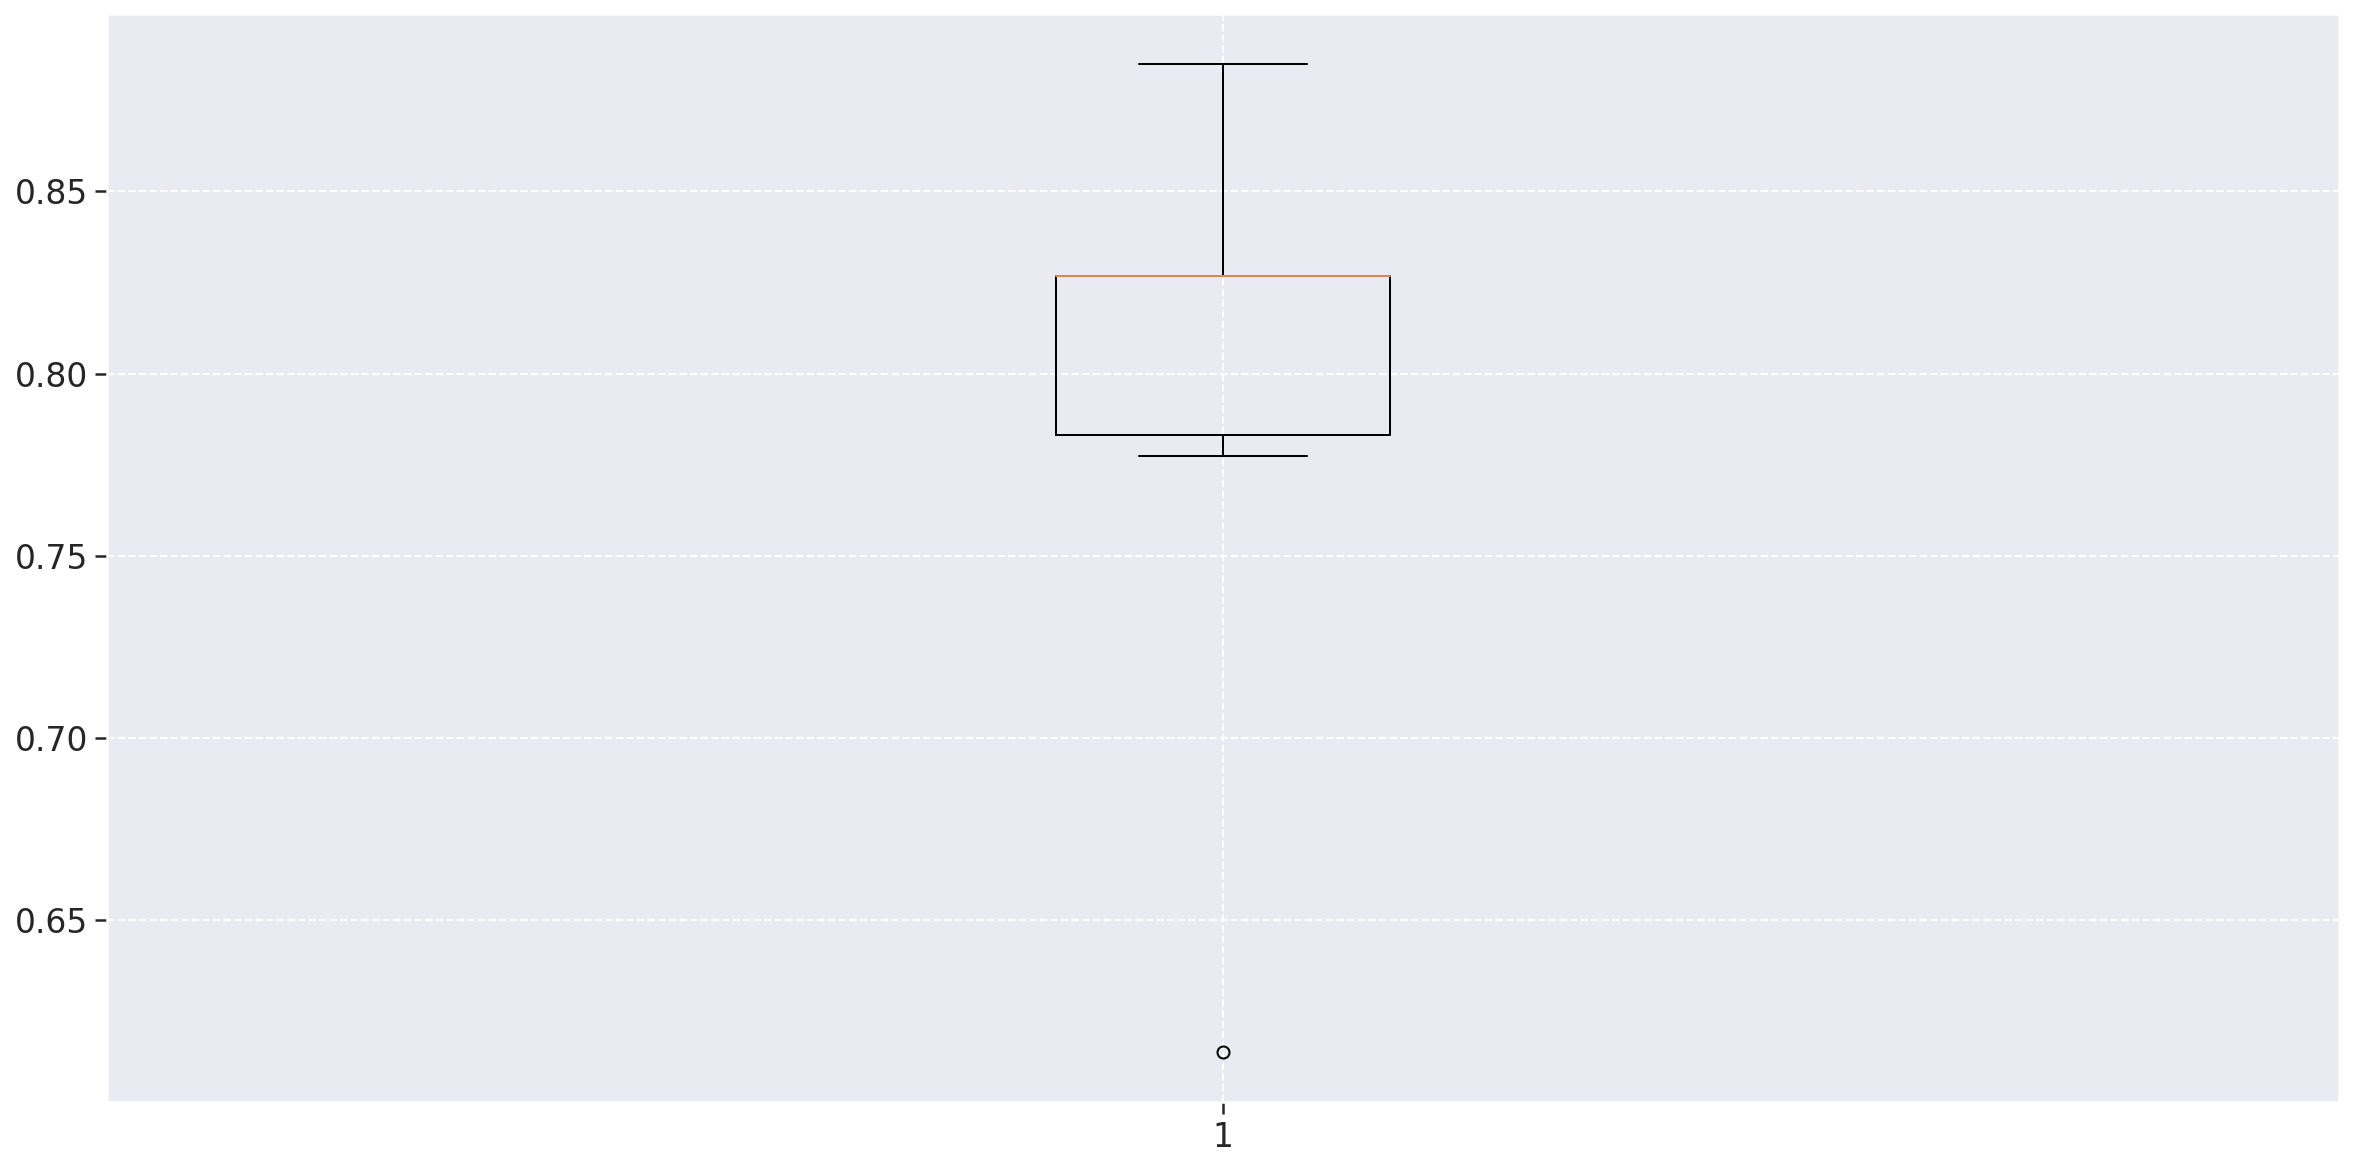

In [72]:
fig = plt.figure(figsize=(20, 10))

plt.boxplot(metrics_df['total'])

In [76]:
metrics_df

,m1,m2,m3,m4,m6,repository,version,ncloc,code_quality,testing_status,maintainability,Reliability,total
0,1.000000,0.333333,1.000000,1.0,1.000000,Archives,03-10-2021-15-47,239,0.770000,1.000000,0.385000,0.500000,0.885000
1,1.000000,0.333333,1.000000,1.0,0.833333,Archives,13-09-2021-15-00,109,0.770000,0.883333,0.385000,0.441667,0.826667
2,1.000000,0.333333,1.000000,1.0,0.833333,Profile,03-10-2021-15-48,112,0.770000,0.883333,0.385000,0.441667,0.826667
3,1.000000,0.333333,1.000000,1.0,0.833333,Profile,13-09-2021-14-00,112,0.770000,0.883333,0.385000,0.441667,0.826667
4,0.880000,0.040000,1.000000,1.0,0.920000,Frontend,03-10-2021-15-49,1417,0.633600,0.944000,0.316800,0.472000,0.788800
5,0.500000,0.250000,1.000000,1.0,0.500000,Frontend,13-09-2021-20-00,48,0.577500,0.650000,0.288750,0.325000,0.613750
6,0.942308,0.019231,0.923077,1.0,0.903846,Frontend,17-10-2021-15-30,4874,0.621923,0.932692,0.310962,0.466346,0.777308


# Metrics to file

In [77]:
metrics_df.to_excel('./data/fga-eps-mds-2021_1-PC-GO1-TO-DATASET-ANALYSIS_DATE.xlsx', index = False)
metrics_df.to_csv('./data/fga-eps-mds-2021_1-PC-GO1-TO-DATASET-ANALYSIS_DATE.csv', index = False)